# Project Quipu: data pre-processing 

This notebook is _not_ ready to execute. Be careful when running this. I am attaching to the public database for reference because future projects might find it useful.

## Specs

Aim to have uniform dataset design, so maximal amount of code can be reused. Store everything in Pandas DataFrames. 
    
    DataFrame.trace -> gives a numpy trace 
    DataFrame.nanopore -> gives a unique identified for the experiment. 
                          Caution with across samples
    DataFrame.Filter -> True if the trajectory passes the filtration step, false if it does not.
    DataFrame.Bound -> True if there is an antibody bound

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import seaborn
import h5py
import glob
from nptdms import TdmsFile
%matplotlib inline

from Quipu.process import measureUnfoldedLevel
import Quipu


/home/kmisiunas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%config InlineBackend.figure_format='retina'

# NBell barcodes

Designed to read and learn from Nick Bell data published in Nature Nanotechnology.

In [32]:
# information from file names

import re, glob, random
def getBarcodeFromFile(path: str):
    return re.findall(r'/[0-9]{3}[/+]', path)[0][1:-1]

def getNanoporeFromFile(path: str):
    try:
        return int(re.findall(r'NP\d+[-/]', path)[0][2:-1])
    except:
        return random.randint(1000, 2000)
    

def getNickBellIdFromFile(path: str):
    "get id that Nick Bell assigned to this track (useful for loading the correct description file later)"
    return int(re.findall(r'Separateevent[ ]*\d+.tdms', path)[0][13:-5])

In [27]:
# TDMS importers

def tdmsFindTraceBrakes(timeSeries):
    "find places where tracks should be broken up. Gives coordinates where all new stuff starts"
    dt = timeSeries[:-1] - timeSeries[1:]
    return (np.argwhere(dt>0) + 1).reshape((-1,))

def tdmsBreakTraces(timeSeries, currentSeries):
    "creates a list of traces, besed on traces file"
    return np.split( currentSeries, tdmsFindTraceBrakes(timeSeries) )

def tdmsGetMultipleTraces(file: str):
    "ectracts multiple traces from single file"
    tdms_file = TdmsFile(file)
    timeSeries = tdms_file.group_channels('Untitled')[1].data # typical, but not tested
    currentSeries = tdms_file.group_channels('Untitled')[0].data
    return tdmsBreakTraces(timeSeries, currentSeries)

def tdmsGetSingleTrace(file: str):
    "gets single trace from a TDMS file"
    tdms_file = TdmsFile(file)
    return tdms_file.group_channels('Untitled')[0].data

In [59]:
# Area based filration 

from scipy.optimize import curve_fit

#areas = dataset[dataset.nanopore==7][dataset.barcode == '000'].trace.apply( lambda l: -l.sum())


def fitCurrentAreaFilter(areas, verbose = True):
    "function fits a normal distibution to the area distributions"
    hist, bin_edges = np.histogram(areas, 100, range = (0, 200), density=True)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [np.max(hist), np.mean(areas), np.std(areas)]

    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

    if verbose:
        # Show results
        hist_fit = gauss(bin_centres, *coeff)
        pyplot.plot(bin_centres, hist, label='Test data')
        pyplot.plot(bin_centres, hist_fit, label='Fitted data')
        pyplot.show()
        print('Fitted mean = ', coeff[1])
        print('Fitted standard deviation = ', coeff[2])
    return {"mu" : coeff[1], "sigma" :  coeff[2]}


def isCurrentBlockadeAbnormal(dataset, filterSTD = 2, verbose = False):
    "returns array of values that are close to normally distributed current blockades"
    areas = dataset.trace.apply( lambda l: -l.sum())
    fit = fitCurrentAreaFilter(areas, verbose)
    upper = fit["mu"] + filterSTD * fit["sigma"]
    lower = fit["mu"] - filterSTD * fit["sigma"]
    return areas.apply( lambda A: (A > upper or A < lower))

In [42]:
# Build Datasets one file at the time (useful for metadata gathering)

def buildDatasetFromTDMS(directory: str, barcode: str):
    # get raw files
    rawTracesFile = glob.glob(directory + "/Timed events.tdms")[0]
    rawTraces = tdmsGetMultipleTraces(rawTracesFile)
    simple = {
        "trace"   : rawTraces,
        "barcode" : [barcode] * len(rawTraces),
        "nanopore": [getNanoporeFromFile(directory)] * len(rawTraces),
        "traceHash": list(map(lambda x: hash(str(x)), rawTraces))
    }
    data = pd.DataFrame(simple)
    
    # add labels for data with abnormal current blocade
    data["Filter"] = isCurrentBlockadeAbnormal(data) == False # verbose = True
    data["nbell_quality"] = False
    
    try:
        # add more data about selected experiments
        cleanTracesFiles = glob.glob(directory + "/Separateevent*.tdms")
        labelFile = glob.glob(directory + "/Peak info.dat")[0]
        labelNames = [
                "nbell_peaks_first_half",
                "nbell_peaks_second_half",
                "nbell_barcode",
                "nbell_positive_barcode"]
        nbellLabels = pd.read_csv(labelFile, 
            delimiter='\t', skiprows=[0], names = labelNames )

        # find tracks by hash 
        referenceHash = pd.Index(data.traceHash)
        qualityTraces = [] # ugly python :(
        for file in cleanTracesFiles:
            nbell_id = getNickBellIdFromFile(file)
            traceHash = hash( str( tdmsGetSingleTrace(file) ))
            try:
                loc = referenceHash.get_loc(traceHash)
                qualityTraces.append([loc, nbell_id])
            except: 
                print("Warning: could not find hash for file ", file)

        ## add columns in the dataset
        for name in labelNames: data[name] = np.nan

        ## add nbell annotations from Peak info.dat
        for i in qualityTraces:
            data.at[i[0], 'nbell_quality'] = True
            data.at[i[0], "nbell_peaks_first_half"] = \
                nbellLabels.loc[i[1]-1, "nbell_peaks_first_half"]
            data.at[i[0], "nbell_peaks_second_half"] = \
                nbellLabels.loc[i[1]-1, "nbell_peaks_second_half"]
            data.at[i[0], "nbell_barcode"] = \
                nbellLabels.loc[i[1]-1, "nbell_barcode"] -1 # correction 
            data.at[i[0], "nbell_positive_barcode"] = \
                nbellLabels.loc[i[1]-1, "nbell_positive_barcode"]
    except:
        print("Failed to find Nick's labeled data")
    
    return data.drop('traceHash', 1)


In [10]:
# main dataset of single datas

dirs = glob.glob("/home/kmisiunas/Data/DNA_barcode/raw/separate/*/*/" )

dataset = pd.concat(
    list(map( lambda d: buildDatasetFromTDMS(d, getBarcodeFromFile(d)), dirs )),
    ignore_index=True
)

dataset.to_hdf("/home/kmisiunas/Data/DNA_barcode/dataset.hdf5", "single", mode = 'w')

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['barcode', 'trace']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [11]:
# test dataset: Even

dirs = glob.glob("/home/kmisiunas/Data/DNA_barcode/raw/mixes/Mix2-001,011,101,111/*/" )

datasetTestEven = pd.concat(
    list(map( lambda d: buildDatasetFromTDMS(d, '001,011,101,111'), dirs )),
    ignore_index=True
)

datasetTestEven.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestOdd.hdf5", "single", mode = 'w')

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['barcode', 'trace']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [12]:
# test dataset: odd

dirs = glob.glob("/home/kmisiunas/Data/DNA_barcode/raw/mixes/Mix1-000,010,100,110/*/" )

datasetTestOdd = pd.concat(
    list(map( lambda d: buildDatasetFromTDMS(d, '000,010,100,110'), dirs )),
    ignore_index=True
)

datasetTestOdd.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestEven.hdf5", "single", mode = 'w')

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['barcode', 'trace']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [13]:
# test dataset: mix

dirs = glob.glob("/home/kmisiunas/Data/DNA_barcode/raw/mixes/MixALL/*/" )

datasetTestMix = pd.concat(
    list(map( lambda d: buildDatasetFromTDMS(d, 'All'), dirs )),
    ignore_index=True
)

datasetTestMix.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestMix.hdf5", "single", mode = 'w')

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['barcode', 'trace']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [14]:
# individual with antibodies

dirs = glob.glob("/home/kmisiunas/Data/DNA_barcode/raw/individual_with_antibodies/*/*/" )

datasetWithAntibodies = pd.concat(
    list(map( lambda d: buildDatasetFromTDMS(d, getBarcodeFromFile(d)), dirs )),
    ignore_index=True
)

datasetWithAntibodies.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetIndividualWithAntibodies.hdf5", "single", mode = 'w')

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['barcode', 'trace']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [15]:
# multiplexed

dirs = glob.glob("/home/kmisiunas/Data/DNA_barcode/raw/multiplexed/*/" )

datasetMultiplexed = pd.concat(
    list(map( lambda d: buildDatasetFromTDMS(d, 'All'), dirs )),
    ignore_index=True
)

datasetMultiplexed.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetMultiplexed.hdf5", "single", mode = 'w')

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['barcode', 'trace']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [3]:
# load from memory

dataset =         pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/dataset.hdf5")
datasetTestEven = pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestEven.hdf5")
datasetTestOdd =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestOdd.hdf5")
datasetTestMix =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestMix.hdf5")
datasetWithAntibodies =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetIndividualWithAntibodies.hdf5")
datasetMultiplexed =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetMultiplexed.hdf5")

def saveAllDatasets():
    dataset.to_hdf("/home/kmisiunas/Data/DNA_barcode/dataset.hdf5", "single", mode = 'w')
    datasetTestEven.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestEven.hdf5", "single", mode = 'w')
    datasetTestOdd.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestOdd.hdf5", "single", mode = 'w')
    datasetTestMix.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestMix.hdf5", "single", mode = 'w')
    datasetWithAntibodies.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetIndividualWithAntibodies.hdf5", "single", mode = 'w')
    datasetMultiplexed.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetMultiplexed.hdf5", "single", mode = 'w')

In [32]:
# In Multiplexed dataset, not all states are bound

unbound_sets = [
    #barcode: nanopore
    ('011', 35),
    ('011', 36),
    ('011', 37),
    ('011', 38),
    ('011', 39), 
    ('011', 40), 
    ('011', 41)
]

selection = datasetWithAntibodies[["barcode", "nanopore"]]\
                        .apply(tuple, axis = 1)\
                        .isin(unbound_sets)

datasetWithAntibodies.loc[selection, 'Bound'] = False



In [33]:
datasetWithAntibodies.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetIndividualWithAntibodies.hdf5", "single", mode = 'w')


/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->['barcode', 'trace', 'TraceSmooth']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


### Extra data from Nick Bell

In [43]:
# main dataset of single datas

dirs = glob.glob("/home/kmisiunas/Data/DNA_barcode/raw/nbell_extra_data/*/*/" )

datasetExtra = pd.concat(
    list(map( lambda d: buildDatasetFromTDMS(d, getBarcodeFromFile(d)), dirs )),
    ignore_index=True
)

datasetExtra.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetExtra.hdf5", "single", mode = 'w')

Failed to find Nick's labeled data
Failed to find Nick's labeled data
Failed to find Nick's labeled data
Failed to find Nick's labeled data
Failed to find Nick's labeled data
Failed to find Nick's labeled data


/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['barcode', 'trace']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [ ]:
datasetExtra

## Add antibody binding properties

In [7]:
datasetWithAntibodies =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetIndividualWithAntibodies.hdf5")


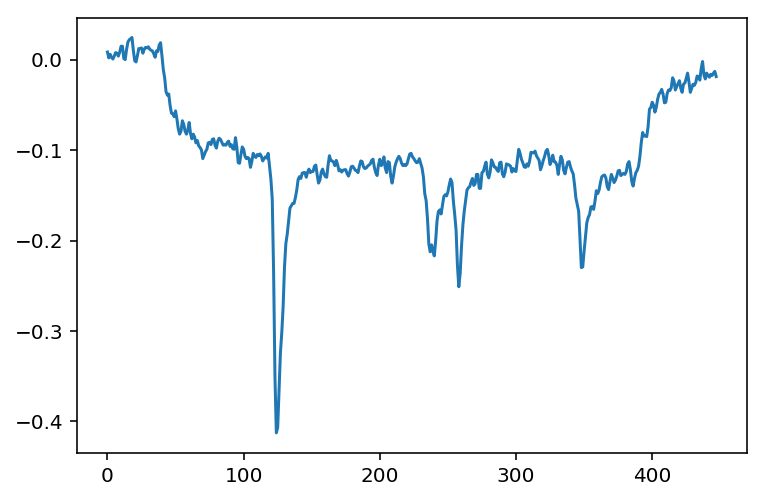

In [30]:
pyplot.plot(
  datasetWithAntibodies.trace[20]
)

In [31]:
len(datasetWithAntibodies)

41936

In [32]:
(datasetWithAntibodies.nbell_barcode < 9).sum()

5729

In [33]:
5729. /41936

0.13661293399465851

In [35]:
datasetWithAntibodies['Bound'] = True

In [224]:
dataset =         pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/dataset.hdf5")
datasetTestEven = pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestEven.hdf5")
datasetTestOdd =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestOdd.hdf5")
datasetTestMix =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestMix.hdf5")
datasetWithAntibodies =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetIndividualWithAntibodies.hdf5")
datasetMultiplexed =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetMultiplexed.hdf5")
datasetExtra =    pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetExtra.hdf5")

In [38]:
dataset['Bound'] = False
datasetTestEven['Bound'] = False
datasetTestOdd['Bound'] = False
datasetTestMix['Bound'] = False
datasetWithAntibodies['Bound'] = True
datasetMultiplexed['Bound'] = np.nan
datasetExtra['Bound'] = False

In [225]:
dataset.to_hdf("/home/kmisiunas/Data/DNA_barcode/dataset.hdf5", "single", mode = 'w')
datasetTestEven.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestEven.hdf5", "single", mode = 'w')
datasetTestOdd.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestOdd.hdf5", "single", mode = 'w')
datasetTestMix.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestMix.hdf5", "single", mode = 'w')
datasetWithAntibodies.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetIndividualWithAntibodies.hdf5", "single", mode = 'w')
datasetMultiplexed.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetMultiplexed.hdf5", "single", mode = 'w')

datasetExtra.to_hdf("/home/kmisiunas/Data/DNA_barcode/datasetExtra.hdf5", "single", mode = 'w')

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['barcode', 'trace']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['barcode', 'trace']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


# Folded / Unfolded events

Dataset from Nik Erman. It has no barcodes. General observations:

 - about 10% of the data has a knot or other type of peak in the middle of the DNA. 

0
NE7_5_600
-4989.57084582


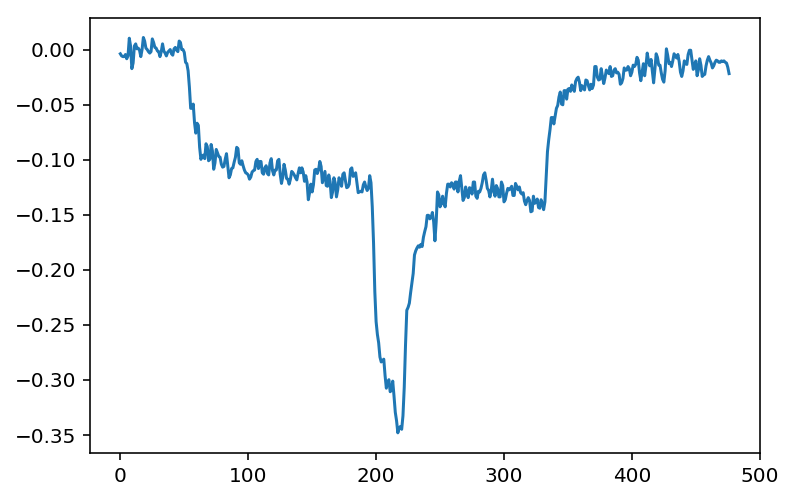

In [56]:
tmp = pd.read_hdf("/home/kmisiunas/Data/raw/fold_unfold_dataset.hdf5")

i = 46
tmp.iloc[i].current_nA |> pyplot.plot
tmp.iloc[i].foldbool |> print
tmp.iloc[i].tag |> print
tmp.iloc[i].logZ |> print

In [60]:
tmp.keys()

Index(['eventno', 'area_fC', 'current_nA', 'currentbaseline_nA', 'duration_ms',
       'file', 'rms_nA', 'start_frame', 'start_ms', 'foldbool', 'start',
       'stop', 'foldlength', 'foldratio', 'duration', 'level1', 'level2',
       'logZ', 'ECDcut', 'tag', 'voltage', 'fit'],
      dtype='object')

In [69]:
# Prepare the dataset

dataset = pd.read_hdf("/home/kmisiunas/Data/raw/fold_unfold_dataset.hdf5")

dataset = tmp.rename(
    columns={'current_nA': 'trace', 'tag': 'nanopore', "foldbool": "Folded"}
)

dataset["Filter"] = True # nik already filtered them 

dataset.to_hdf("/home/kmisiunas/Data/folds/dataset.hdf5", "folded", mode = 'w')

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['trace', 'file', 'nanopore', 'fit']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


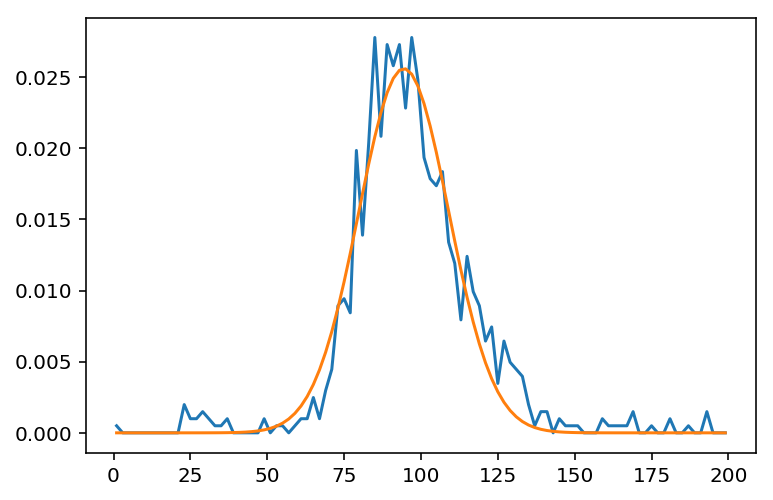

Fitted mean =  94.4206010317
Fitted standard deviation =  14.6362467315


{'mu': 94.420601031695412, 'sigma': 14.636246731539845}

In [68]:
fitCurrentAreaFilter(dataset[dataset.nanopore == "NE7_7_600"].area_fC)

The data has already been filtered by current blocade area by Nik Erman.

---

# Filtration

There seems to be a lot of traces with odd event types, even area filtration step. This is due to big variability in pore shape and protein structures. 

Here, we will attempt to identify those datasets and add `Filter=False` flag 

**Observations**
 - NBell had only labeled data that was nearly perfect - it should all be included.
 
**Specs**
```
UnfoldedLevel - current level of unfolded traces in that experiment
area - area under the trace
TraceMax - maximum current displacement (negative)
TraceStd - Standard deviation of the trace
TraceMean - Mean of the trace
TraceLength - length of the trace
PulseLength - length of the pulse: defined as range where trace < UnfoldedLevel /2
FoldLength - length at higher level: defined as sum where trace < UnfoldedLevel *3/2
TraceSmoothMax - Max current after applying moving window with np.min fn
```

 
 

In [58]:
# method for adding varios metrics into the dataset


def addTraceMetrics(ds):
    "add simple metrics about traces"
    # maximal current drop is important for filtration
    ds['area'] = ds.trace.apply(lambda x: -np.sum(x))
    ds["TraceMax"] = ds.trace.apply(np.min)
    ds["TraceStd"] = ds.trace.apply(np.std)
    ds["TraceMean"] = ds.trace.apply(np.mean)
    ds["TraceLength"] = ds.trace.apply(len)
    return ds

def addPerNanopore(ds):
    ""
    nanopores = ds.nanopore.unique()
    unfoldedLevel = ds.area * 0.0
    for nanopore in nanopores:
        sel = ds.nanopore == nanopore
        unfoldedLevel[sel] = measureUnfoldedLevel( ds[sel & ds.Filter] )
    
    # add back to ds: 
    ds["UnfoldedLevel"] = unfoldedLevel
    return ds

def addPerNanoporeAndBarcode(ds):
    "important to separate them since NBell sometimes reused pores by flushing"
    if 'barcode' not in ds.columns:
        return addPerNanopore(ds)
    nanopores = ds.nanopore.unique()
    barcodes =  ds.barcode.unique()
    unfoldedLevel = ds.area * 0.0
    import itertools
    for nanopore, barcode in itertools.product(nanopores, barcodes):
        sel = (ds.nanopore == nanopore) & (ds.barcode == barcode)
        if sel.sum() > 2:
            unfoldedLevel[sel] = measureUnfoldedLevel( ds[sel & ds.Filter] )
    
    # add back to ds: 
    ds["UnfoldedLevel"] = unfoldedLevel
    return ds

def addAdvancedMetrics(ds):
    "add metrics requring more information"
    # pulse lenght - should be proportional to TraceLength
    def findPulseLength(one):
        #index = np.arange(one.TraceLength)
        #selection = index[one.trace < (one.UnfoldedLevel /2)]
        #return np.max(selection) - np.min(selection)
        selection = one.trace < (one.UnfoldedLevel /2)
        return selection.sum()
    ds["PulseLength"] = ds.apply(findPulseLength, axis=1)
    # pulse legth at 1.5x UnfoldedLevel
    def findHighPulseLength(one):
        selection = one.trace < (one.UnfoldedLevel*3/2)
        return selection.sum()
    ds["FoldLength"] = ds.apply(findHighPulseLength, axis=1)
    # moving window minimum (removes peaks)
    def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    ds["TraceSmoothMax"] = ds.trace.apply(lambda y: np.min(np.max(rolling_window(y, 15), -1)) )
    return ds



In [586]:
# import barcode data

dataset =         pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/dataset.hdf5")
#dataset = pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestEven.hdf5")
#dataset =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestOdd.hdf5")
#dataset =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestMix.hdf5")
#dataset =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetIndividualWithAntibodies.hdf5")
#dataset =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetMultiplexed.hdf5")
#dataset =    pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetExtra.hdf5")

#dataset = pd.read_hdf("/home/kmisiunas/Data/folds/dataset.hdf5")
#dataset= pd.read_hdf("/home/kmisiunas/Data/1peak_middle/dataset.hdf5")


In [587]:
# add extra paramters to the datasets 

#datasetBack = dataset.copy()

dataset = dataset[dataset.trace.apply(len) != 0] # some traces simply don't exist?!
dataset = addPerNanoporeAndBarcode(addTraceMetrics(dataset));
dataset = addAdvancedMetrics(dataset)

In [578]:
# filtration

def filter_rules(series, limits):
    "returns mask"
    return (series >= np.min(limits)) & (series <= np.max(limits))

def filter_gaussain(data, std_fisrt, verbose = False):
    "gaussain filter after selecting first window. Return [mean, std]"
    raw_std = np.std(data)
    raw_mean = np.mean(data)
    points = data[(data > raw_mean - std_fisrt*raw_std) & (data < raw_mean + std_fisrt*raw_std)]
    y, x = np.histogram(points)
    x = (x[1:] + x[:-1]) / 2
    
    def gaussian(x, amp, cen, wid):
        return amp * np.exp(-(x-cen)**2 /wid)
    
    from scipy.optimize import curve_fit
    init_vals = [np.max(y), raw_mean, raw_std]     # for [amp, cen, wid]
    try:
        best_vals, covar = curve_fit(gaussian, x, y, p0=init_vals)
        mean = best_vals[1]
        std  = np.sqrt( best_vals[2] /2 )
    except:
        print("Warrning! Filed to converge in filter_gaussain. going back to simple estimates")
        mean = raw_mean
        std = raw_std
    
    if verbose:
        print("raw: mean=", np.mean(ds.area), "; std=",np.std(ds.area))
        print("fit: mean=", mean, "; std=",std)
        print("after filter: mean=", np.mean(points), "; std=",np.std(points))
        binwidth = np.diff(x)[0]
        pyplot.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth))
        pyplot.plot(x,y, "o")
        x_test = np.arange(min(points), max(points), binwidth/10.0)
        pyplot.plot(x_test, gaussian(x_test, best_vals[0], best_vals[1], best_vals[2]), 'r')
        pyplot.plot([mean - 2.3*std, mean + 2.3*std],[5,5], "rX")
        
    return [mean, std]

def filter_area(ds, verbose = False):
    "returns limits"
    mean, std = filter_gaussain(ds.area, 1, verbose = verbose)
    return [mean - 2.0*std, mean + 2.0*std]

def filter_TraceSmoothMax(ds):
    "filter out events with unusually high traces"
    # paramters tunned by manual inspection on 2018-01-19
    level = ds.UnfoldedLevel.iloc[0]
    return [2.3*level, 0.9*level]

def filter_TraceMax(ds):
    "returns limits"
    # paramters tunned by manual inspection on 2018-01-19
    level = ds.UnfoldedLevel.iloc[0]
    return sorted([level, level*3.2])

# def filter_TraceStd(ds):
#     "returns limits"
#     std = np.std(ds.TraceStd)
#     mean = np.mean(ds.TraceStd)
#     level = ds.UnfoldedLevel.iloc[0]
#     return [mean - 1.9*std, np.min([ np.abs(level),mean + 1.9*std]) ]

# def filter_TraceMean(ds):
#     "returns limits"
#     level = ds.UnfoldedLevel.iloc[0]
#     return sorted([level*0.3, level])


def filterPerNanoporeAndBarcode(ds):
    "filter per nanopore based on all the filters"
    if 'barcode' not in ds.columns:
        return filterPerNanopore(ds)
    nanopores = ds.nanopore.unique()
    barcodes =  ds.barcode.unique()
    filters = ds.Filter 
    import itertools
    for nanopore, barcode in itertools.product(nanopores, barcodes):
        sel = (ds.nanopore == nanopore) & (ds.barcode == barcode)
        if sel.sum() > 0:
            data = ds[sel]
            filters[sel] =  filter_rules(data.area, filter_area(data)) &\
                            filter_rules(data.TraceSmoothMax, filter_TraceSmoothMax(data)) &\
                            filter_rules(data.TraceMax, filter_TraceMax(data))
    
    # add back to ds: 
    filters = filters.fillna(False)
    ds["Filter"] = filters
    return ds

def filterPerNanopore(ds):
    "filter per nanopore based on all the filters"
    nanopores = ds.nanopore.unique()
    filters = ds.Filter 
    import itertools
    for nanopore in nanopores:
        sel = (ds.nanopore == nanopore)
        if sel.sum() > 0:
            data = ds[sel]
            filters[sel] =  filter_rules(data.area, filter_area(data)) &\
                            filter_rules(data.TraceSmoothMax, filter_TraceSmoothMax(data)) &\
                            filter_rules(data.TraceMax, filter_TraceMax(data))
    
    # add back to ds: 
    filters = filters.fillna(False)
    ds["Filter"] = filters
    return ds


barcodes in nanopore= 9 : ['111' '010']


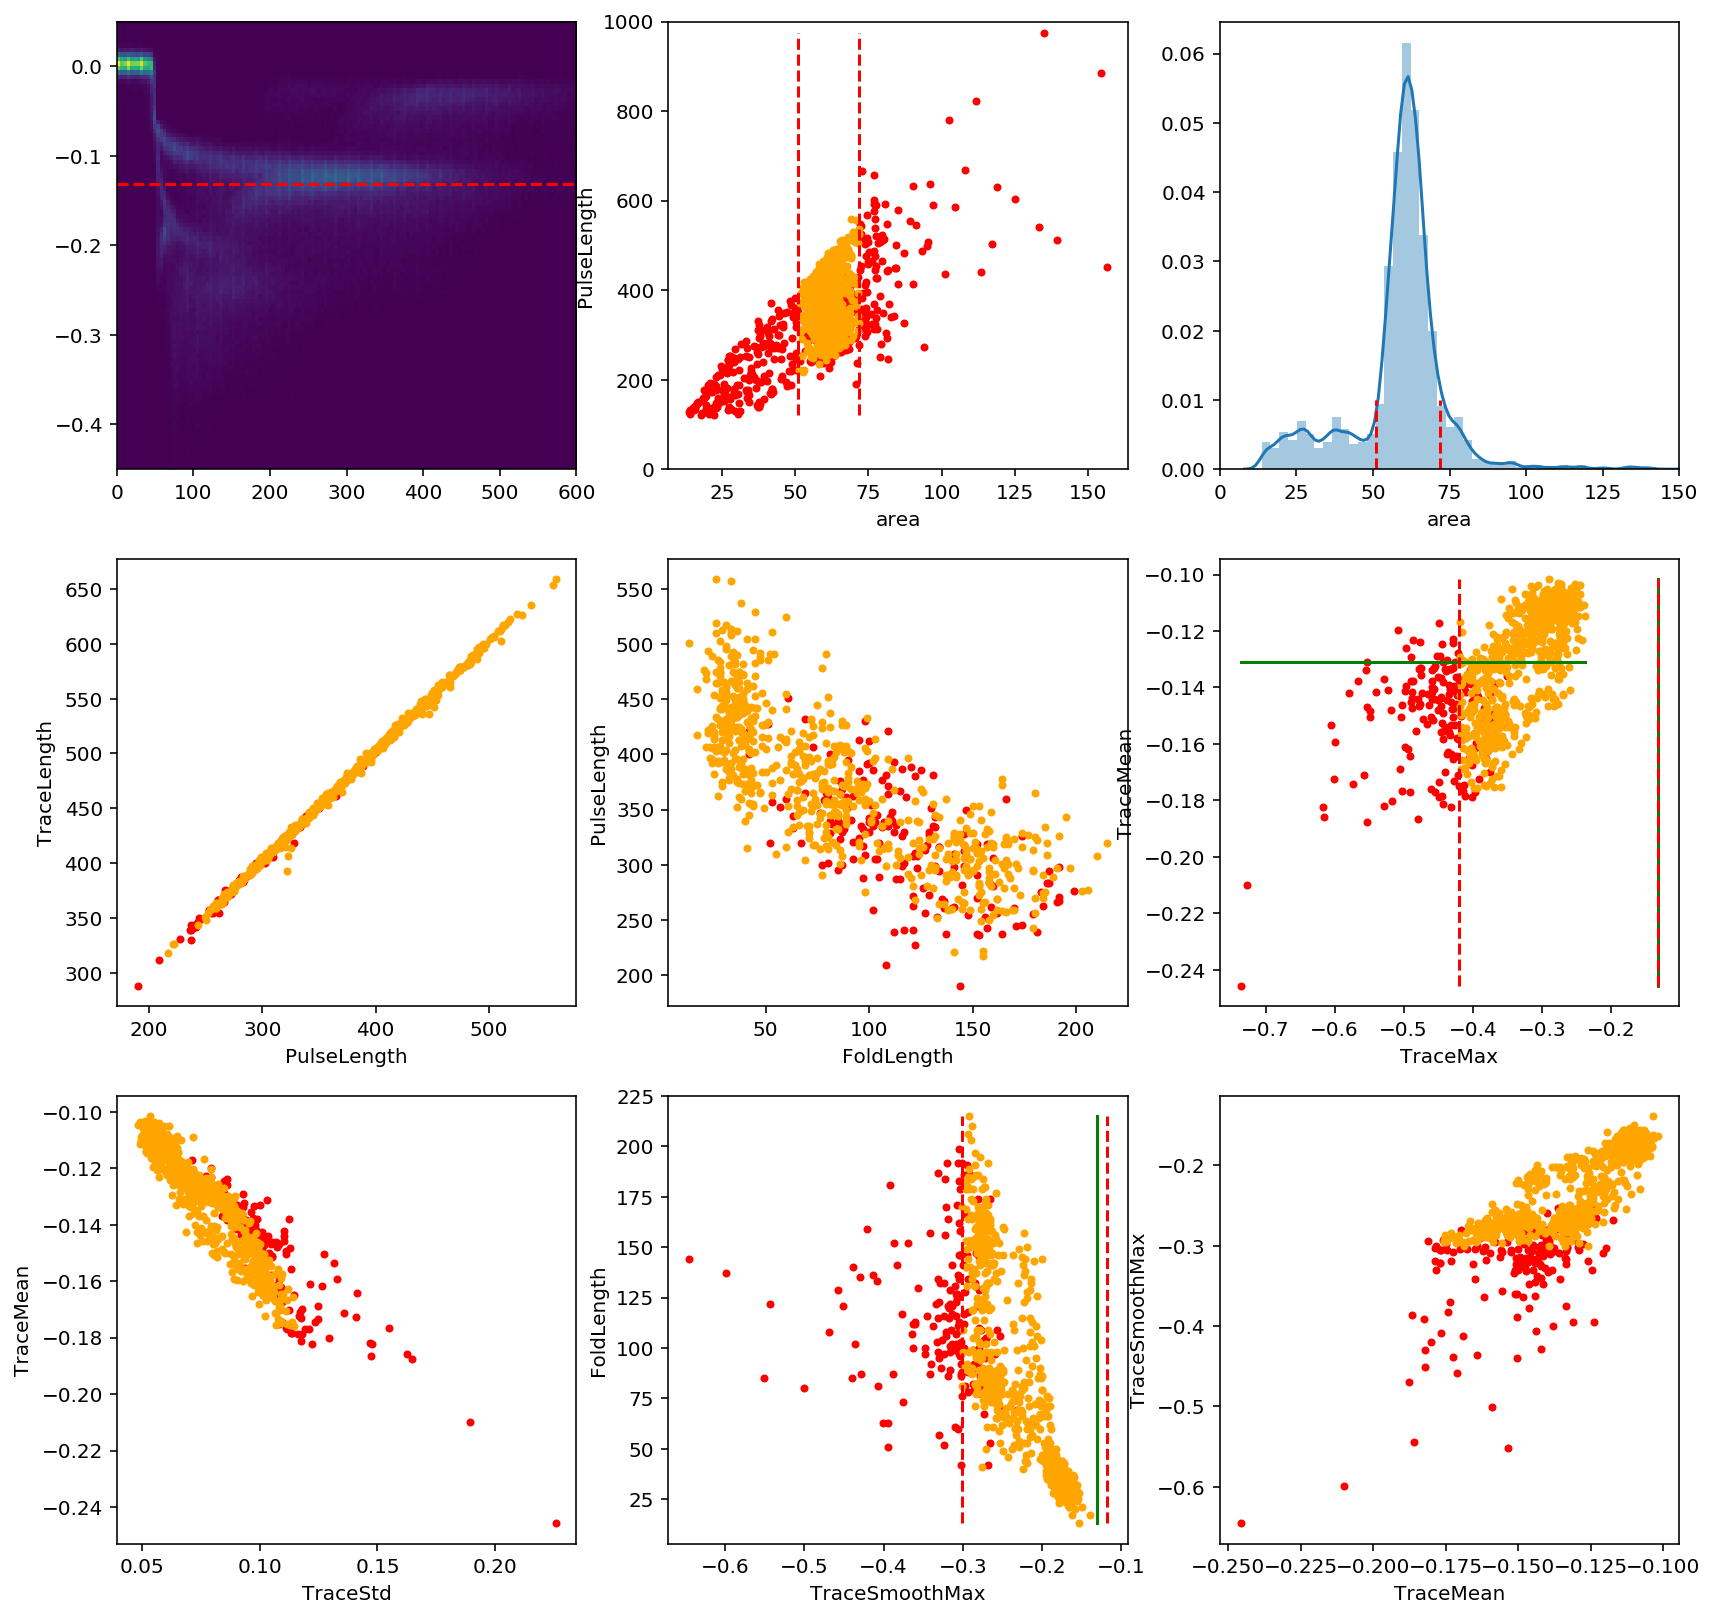

In [588]:
# Inspection

ds = dataset  # select dataset

nanopores = ds.nanopore.unique()
nanopore = nanopores[7]
sel = ds.nanopore == nanopore

barcodes =  ds[sel].barcode.unique()
print("barcodes in nanopore=", nanopore, ":", barcodes)
barcode = barcodes[0]
sel = sel & (ds.barcode == barcode) 

data = ds[sel]

def plotPrarams(ds, x, y):
    #selNB = ds.nbell_barcode < 8
    sel = ds.Filter
    pyplot.plot(ds[~sel][x], ds[~sel][y], '.', color='red' )
    pyplot.plot(ds[sel][x], ds[sel][y], '.', color='orange' )
    #pyplot.plot(ds[selNB][x], ds[selNB][y], '.' )
    pyplot.xlabel(x)
    pyplot.ylabel(y)
    
def minMax(arr): return [np.min(arr), np.max(arr)]

unfolded_level = data.UnfoldedLevel.iloc[0]


# area vs something else
pyplot.figure(figsize=[14,14])


pyplot.subplot(3,3,1)
points = Quipu.process.getIndexedTraces(data)
pyplot.hist2d(points[:,0], points[:,1], 
    bins=(70*2, 50*2),
    range = [[0, 600], [-0.45, 0.05]],
    cmax = 100000/4 # clip max
)
pyplot.plot([0,600], [unfolded_level]*2, 'r--')


pyplot.subplot(3,3,2)
plotPrarams(data, 'area', 'PulseLength')
limits_area = filter_area(data)
pyplot.ylim([0,1000])
pyplot.plot([np.min(limits_area)]*2, minMax(data.PulseLength), 'r--')
pyplot.plot([np.max(limits_area)]*2 ,minMax(data.PulseLength), 'r--')

pyplot.subplot(3,3,3)
seaborn.distplot( data.area )
pyplot.xlim([0,150])
pyplot.plot([np.min(limits_area)]*2, [0,0.01], 'r--')
pyplot.plot([np.max(limits_area)]*2 ,[0,0.01], 'r--')

# Refinement 
# from here remove anything outside the area filter
data = data[filter_rules(data.area, limits_area)]
# reapply filters to see redundand filters
data['Filter'] = filter_rules(data.TraceSmoothMax, filter_TraceSmoothMax(data)) &\
                 filter_rules(data.TraceMax, filter_TraceMax(data))

pyplot.subplot(3,3,4)
plotPrarams(data, 'PulseLength', 'TraceLength')

pyplot.subplot(3,3,5)
plotPrarams(data, 'FoldLength', 'PulseLength')


pyplot.subplot(3,3,6)
plotPrarams(data, 'TraceMax', 'TraceMean')
pyplot.plot([unfolded_level]*2 ,minMax(data.TraceMean), 'g')
pyplot.plot(minMax(data.TraceMax),[unfolded_level]*2 , 'g')
limits_TraceMax = filter_TraceMax(data)
pyplot.plot([np.min(limits_TraceMax)]*2, minMax(data.TraceMean), 'r--')
pyplot.plot([np.max(limits_TraceMax)]*2 ,minMax(data.TraceMean), 'r--')

pyplot.subplot(3,3,7)
plotPrarams(data, 'TraceStd', 'TraceMean')


pyplot.subplot(3,3,8)
plotPrarams(data, 'TraceSmoothMax', 'FoldLength')
limits_TraceSmoothMax = filter_TraceSmoothMax(data)
pyplot.plot([unfolded_level]*2 ,minMax(data.FoldLength), 'g')
pyplot.plot([np.min(limits_TraceSmoothMax)]*2, minMax(data.FoldLength), 'r--')
pyplot.plot([np.max(limits_TraceSmoothMax)]*2 ,minMax(data.FoldLength), 'r--')

pyplot.subplot(3,3,9)
plotPrarams(data,  'TraceMean', 'TraceSmoothMax')


12801   NaN
12155   NaN
11994   NaN
Name: nbell_barcode, dtype: float64

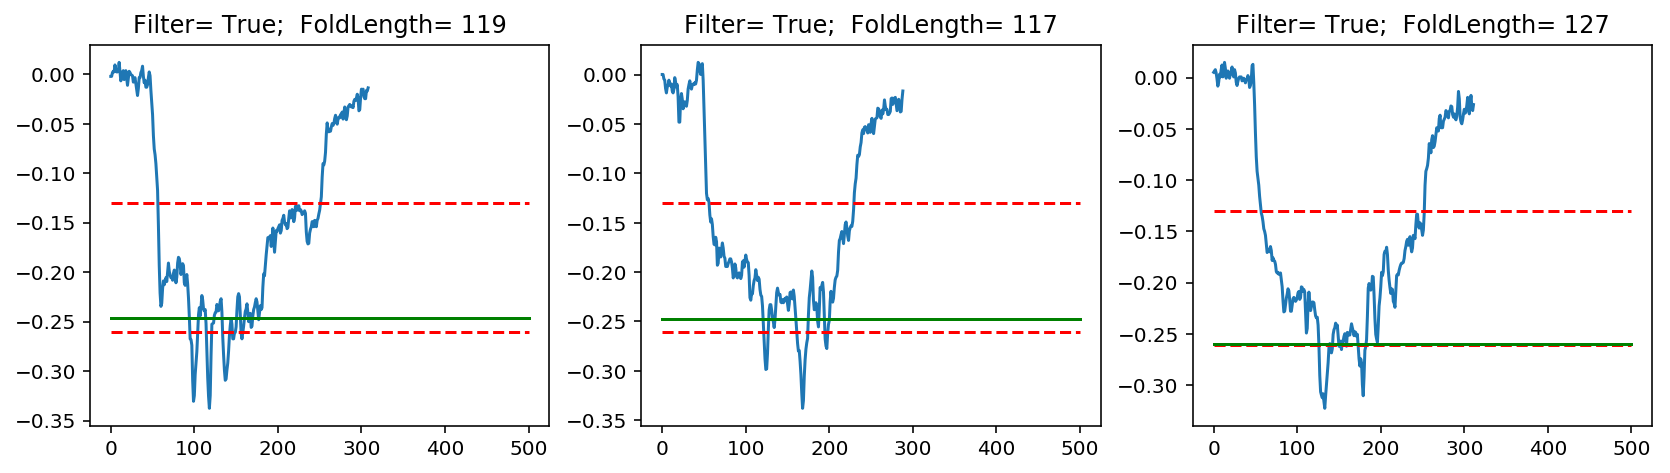

In [442]:
# inspect speccific trace

sel2 = (data.area < 55) & (data.area > 40)
sel2 = data.PulseLength > 450
sel2 = (data.TraceSmoothMax < data.UnfoldedLevel*2.2) & (data.TraceSmoothMax > data.UnfoldedLevel*2.3)
#sel2 = (data.TraceSmoothMax < data.UnfoldedLevel*2.3) & (data.nbell_barcode<8)
#sel2 = (data.TraceSmoothMax > data.UnfoldedLevel*0.95)
#sel2 = (data.TraceMax < data.UnfoldedLevel*3.2) & (data.TraceSmoothMax > data.UnfoldedLevel*2.3)
sel2 = (data.TraceMean < -0.14) & data.Filter 

pyplot.figure(figsize=[14,3.5])
three = data[sel2].sample(3)
for i in range(3):
    one = three.iloc[i]
    pyplot.subplot(1,3,i+1)
    pyplot.plot(one.trace)
    pyplot.plot([0,500], [one.UnfoldedLevel]*2, 'r--')
    pyplot.plot([0,500], [one.UnfoldedLevel*2]*2, 'r--')
    pyplot.plot([0,500], [one.TraceSmoothMax]*2, 'g')
    pyplot.title("Filter= "+str(one.Filter) + ";  FoldLength= "+str(one.FoldLength))

three.nbell_barcode



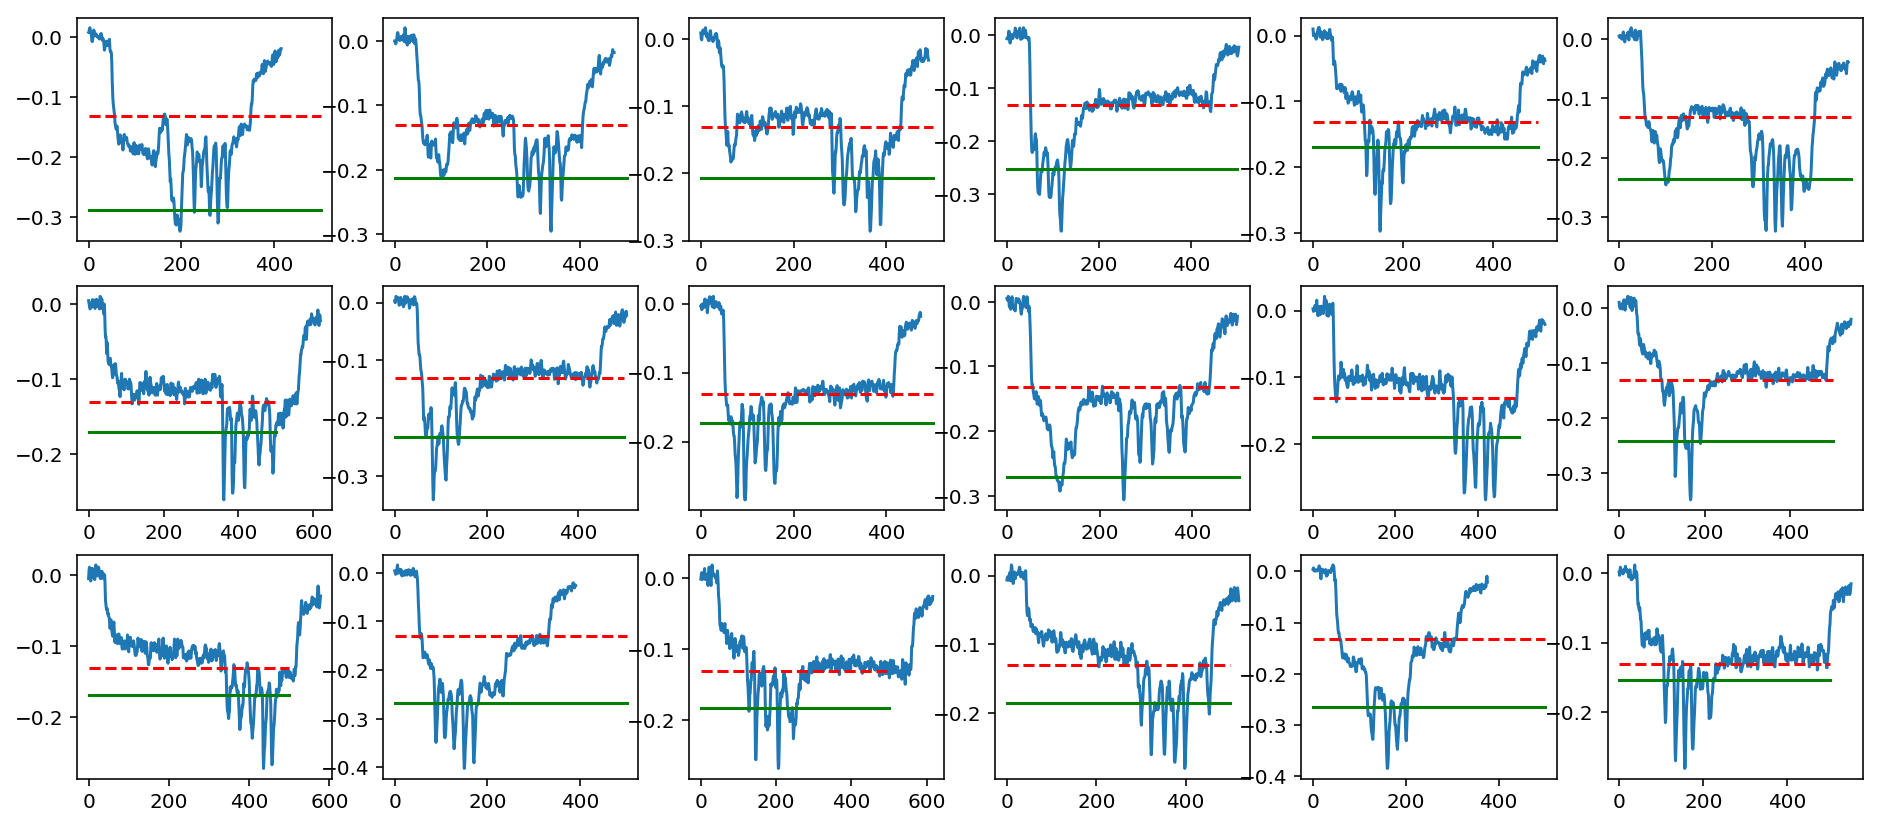

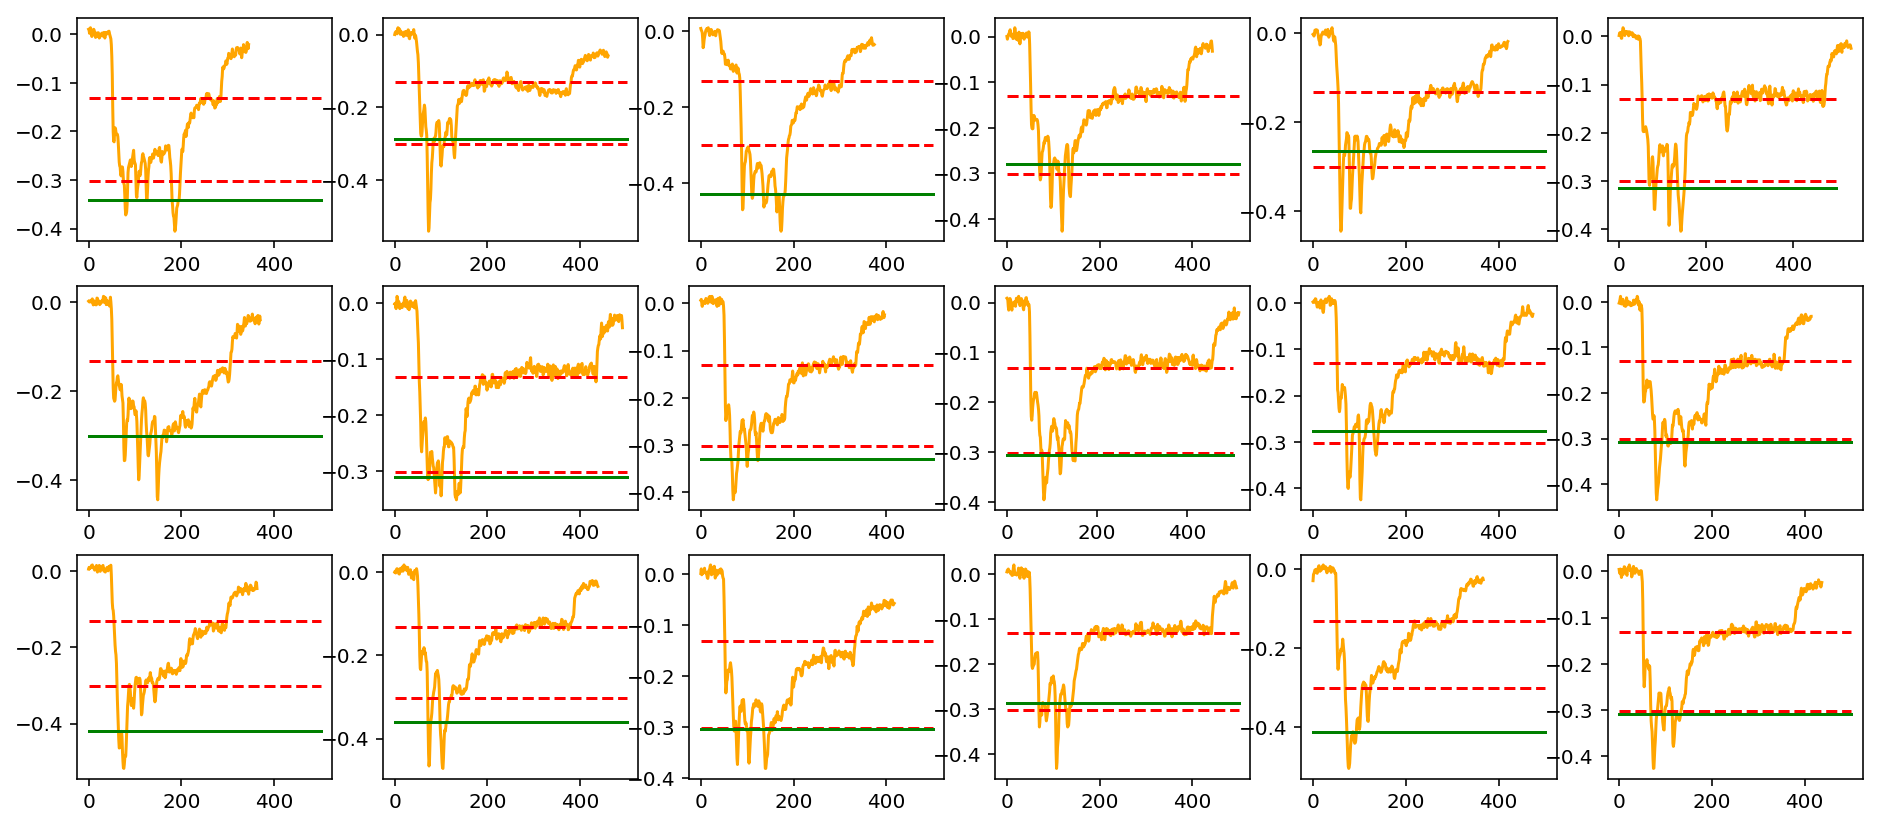

In [589]:
# inspect traces included and excluded by the filters

pyplot.figure(figsize=[16,7])
examples_included = data[data.Filter].sample(3*6)
for i in range(3*6):
    one = examples_included.iloc[i]
    pyplot.subplot(3,6,i+1)
    pyplot.plot(one.trace)
    pyplot.plot([0,500], [one.UnfoldedLevel]*2, 'r--')
    pyplot.plot([0,500], [one.TraceSmoothMax]*2, 'g')
    
pyplot.figure(figsize=[16,7])
examples_excluded = data[~data.Filter].sample(3*6)
for i in range(3*6):
    one = examples_excluded.iloc[i]
    pyplot.subplot(3,6,i+1)
    pyplot.plot(one.trace, color='orange')
    pyplot.plot([0,500], [one.UnfoldedLevel]*2, 'r--')
    pyplot.plot([0,500], [one.UnfoldedLevel*2.3]*2, 'r--')
    pyplot.plot([0,500], [one.TraceSmoothMax]*2, 'g')

In [464]:
# comparison of filters: before and after

sample_count_before = dataset.Filter.sum()
ds = addAdvancedMetrics( addPerNanoporeAndBarcode( addTraceMetrics(dataset)))
sample_count_after  = filterPerNanoporeAndBarcode(ds).Filter.sum()
print("Sample count change: ",sample_count_before, " -> ", sample_count_after)

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Sample count change:  35698  ->  29420


In [ ]:
# Apply new filter and save

def estimateFiltersFor(file):
    print("==== file:", file,"====")
    dataset =         pd.read_hdf(file)
    dataset = dataset[dataset.trace.apply(len) != 0] # some traces simply don't exist?!
    dataset = addAdvancedMetrics( addPerNanoporeAndBarcode( addTraceMetrics(dataset)))
    print("  Loaded dataset with ", len(dataset), " of which there are ", dataset.Filter.sum(), " influded filters")
    dataset = filterPerNanoporeAndBarcode( dataset )
    print("  After filtration number of traces: ", dataset.Filter.sum())
    dataset.to_hdf(file, "1peak", mode = 'w')
    
#estimateFiltersFor("/home/kmisiunas/Data/DNA_barcode/dataset.hdf5")
#estimateFiltersFor("/home/kmisiunas/Data/DNA_barcode/datasetTestEven.hdf5")
#estimateFiltersFor("/home/kmisiunas/Data/DNA_barcode/datasetTestOdd.hdf5")
#estimateFiltersFor("/home/kmisiunas/Data/DNA_barcode/datasetTestMix.hdf5")
#estimateFiltersFor("/home/kmisiunas/Data/DNA_barcode/datasetIndividualWithAntibodies.hdf5")
#estimateFiltersFor("/home/kmisiunas/Data/DNA_barcode/datasetMultiplexed.hdf5")
#estimateFiltersFor("/home/kmisiunas/Data/DNA_barcode/datasetExtra.hdf5")
#estimateFiltersFor("/home/kmisiunas/Data/folds/dataset.hdf5")
estimateFiltersFor("/home/kmisiunas/Data/1peak_middle/dataset.hdf5")

---

# Normalisation Development

### Now look for outliers within different datasets

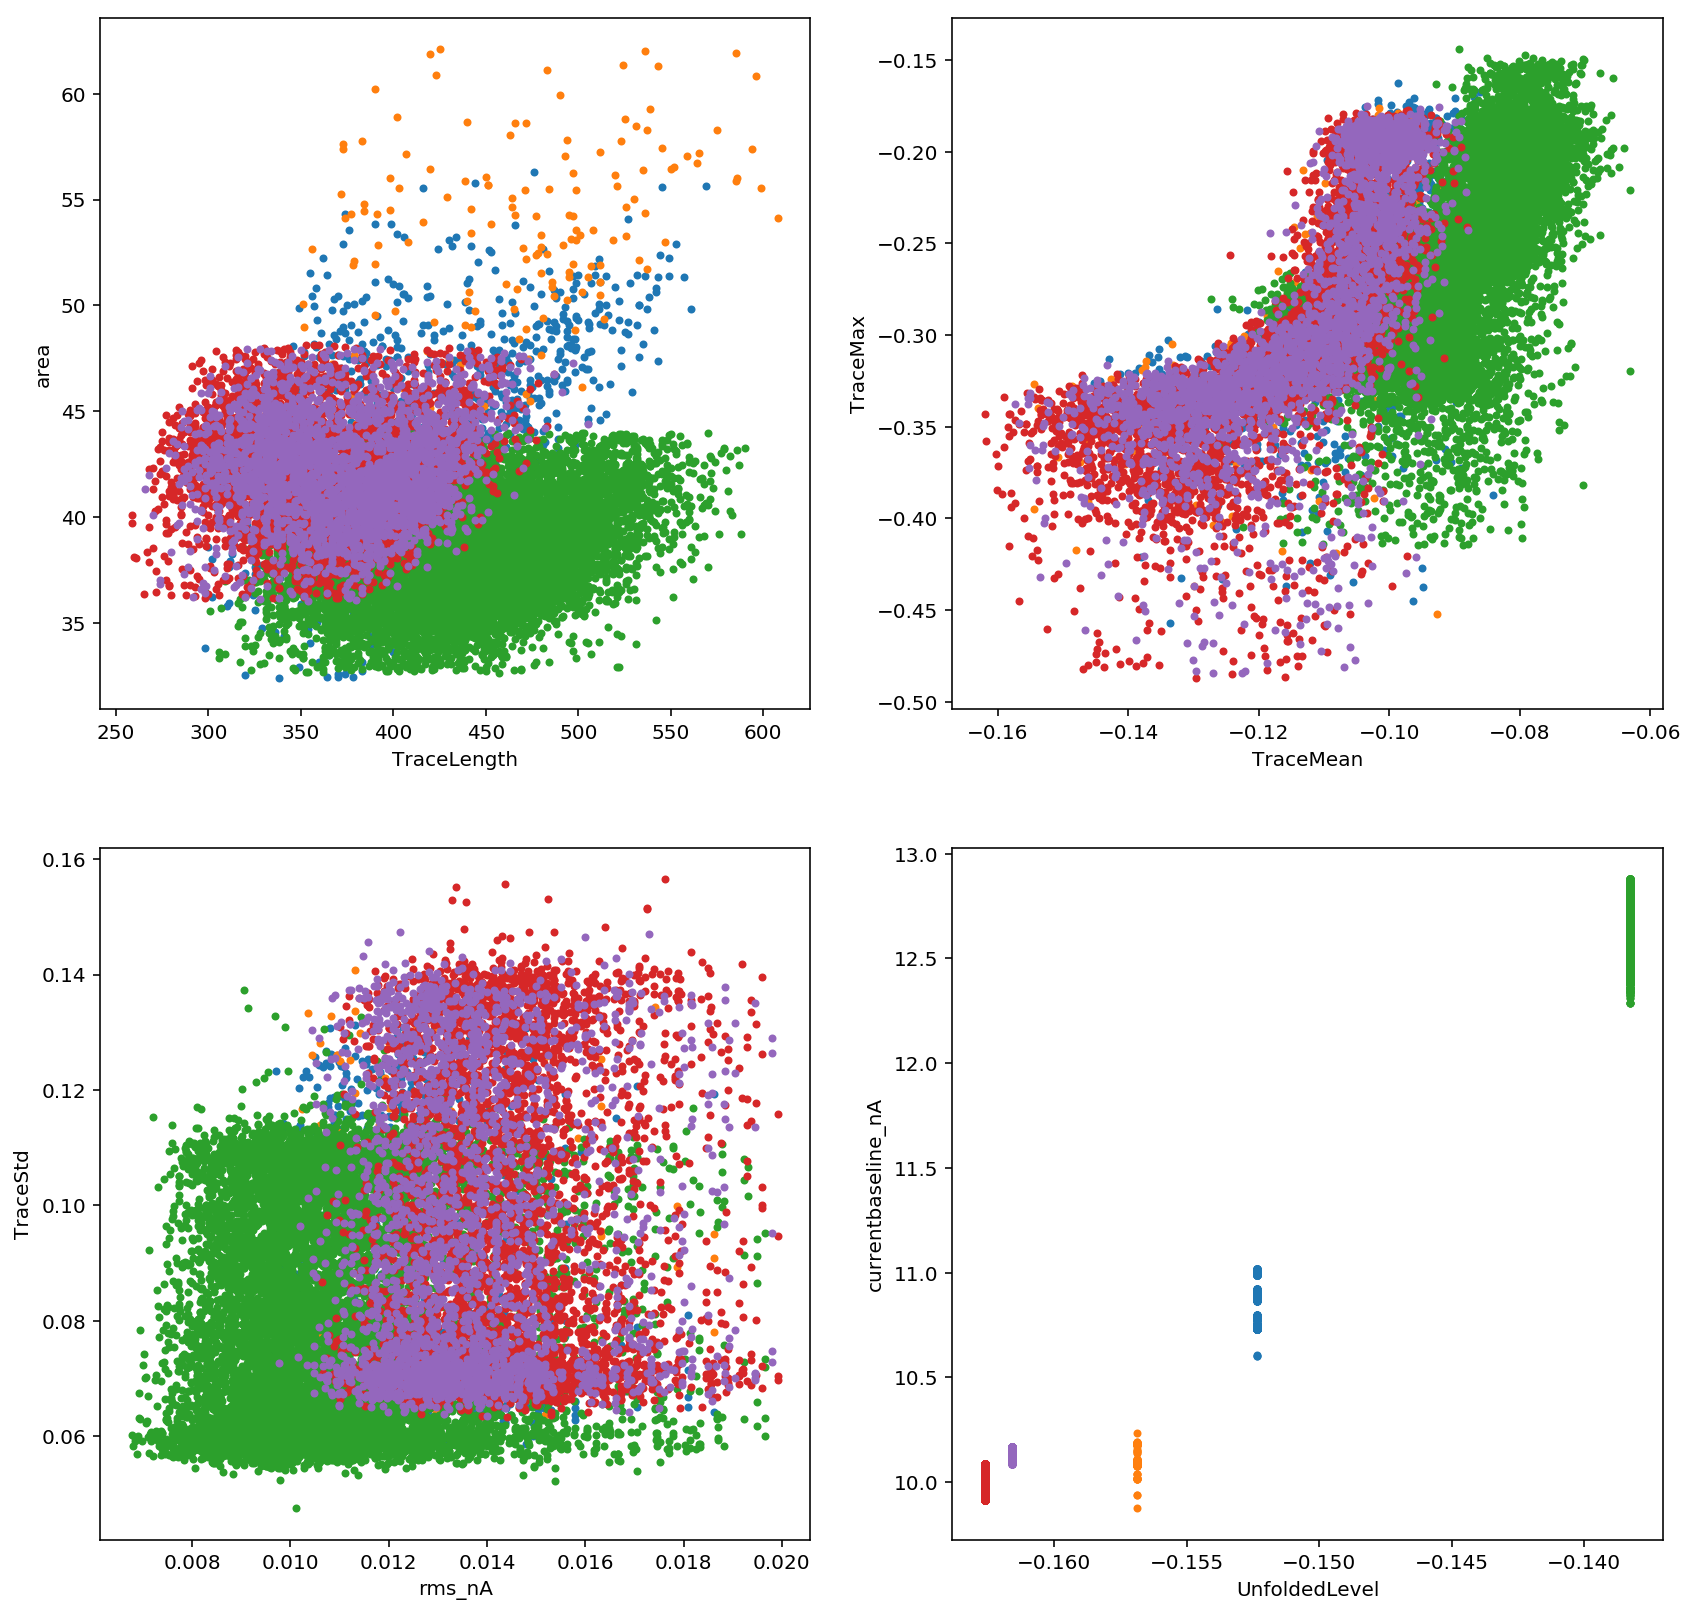

In [425]:
ds = dataset_time_SNP

nanopores = ds.nanopore.unique()

def plotPraramsAll(ds, x, y):
    for nanopore in nanopores:
        data = ds[ds.Filter & (ds.nanopore == nanopore)]
        pyplot.plot(data[x], data[y], '.' )
    pyplot.xlabel(x)
    pyplot.ylabel(y)
    
    
pyplot.figure(figsize=[14,14])

pyplot.subplot(2,2,1)
plotPraramsAll(ds, 'TraceLength', 'area')

pyplot.subplot(2,2,2)
plotPraramsAll(ds,'TraceMean', 'TraceMax')

pyplot.subplot(2,2,3)
plotPraramsAll(ds, 'rms_nA','TraceStd')

pyplot.subplot(2,2,4)
plotPraramsAll(ds, 'UnfoldedLevel', 'currentbaseline_nA')

Filter=  True
nanopore=  160602c6-14
barcode=  1


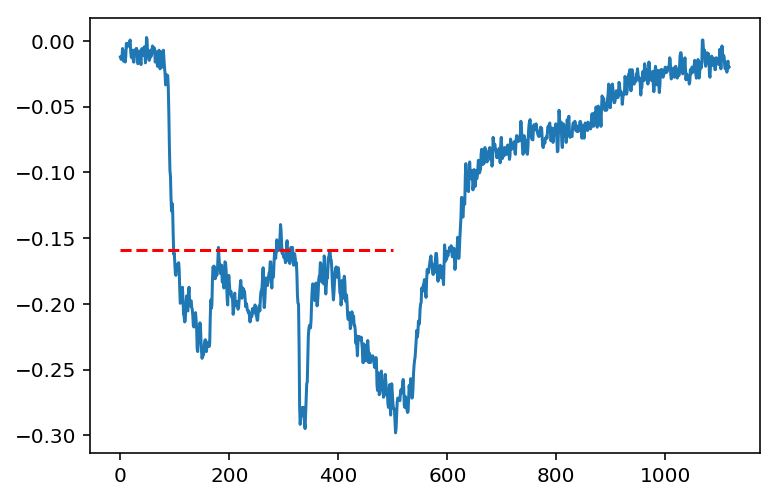

In [416]:
# inspect speccific trace

sel2 = (ds.TraceLength > 1000) & (ds.Filter)

one = ds[sel2].sample().iloc[0]
pyplot.plot(one.trace )
pyplot.plot([0,500], [unfolded_level]*2, 'r--')
print("Filter= ", one.Filter)
print("nanopore= ", one.nanopore)
print("barcode= ", one.barcode)

### sumarise changes

In [380]:
original = pd.read_hdf("/home/kmisiunas/Data/1peak_middle/dataset_snp.hdf5")

print("Total      traces:", len(original))
print("Original   traces:", original.Filter.sum() )
print("New filter traces:", dataset_snp.Filter.sum() )

Total      traces: 28658
Original   traces: 20916
New filter traces: 18834


In [ ]:
# finaly export new filters

dataset_snp.to_hdf("/home/kmisiunas/Data/1peak_middle/dataset_snp.hdf5", "1peak", mode = 'w')
dataset_antibody.to_hdf("/home/kmisiunas/Data/1peak_middle/dataset_antibody.hdf5", "1peak", mode = 'w')
dataset_time_SNP.to_hdf("/home/kmisiunas/Data/1peak_middle/dataset_SNP_time_dependent.hdf5", "1peak", mode = 'w')

# Developing normalisation

Mostly meant for 1peak data since there is massive variation. Use the datasets above to normalise

Aim: produce traces that have normal level around -1 and fit within 800 samples

Idea: measure average area of traces and average level, then for all the traces in that dataset apply same re-sampling to roughly scale within the specified window. Then scale the levels

/1peak_middle/sa/0control_quantifying/0302 blank carrier/c8
unfolded_level -0.14955784004
mean_area 60.83575820856012
length_normalisation 1.47503222885


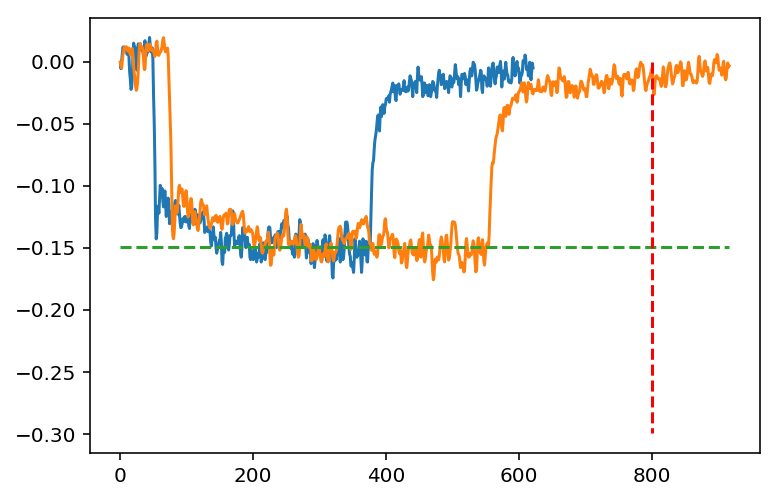

In [577]:
from Quipu.process import measureUnfoldedLevel

ds = dataset_snp

nanopores = ds.nanopore.unique()

nanopore = nanopores[21]
print(nanopore)

sel = (ds.nanopore == nanopore) & (ds.Filter)
data = ds[sel]

unfolded_level = data.UnfoldedLevel.iloc[0]
print("unfolded_level", unfolded_level)

mean_area = data[data.Filter].area.mean()
print("mean_area",mean_area)

expected_length = np.abs( mean_area / unfolded_level )

length_normalisation = 600.0 / expected_length
print("length_normalisation", length_normalisation)

random_trace = data.sample().iloc[0].trace

import scipy.signal as signal
normalised_trace = signal.resample(random_trace, int( len(random_trace) * length_normalisation)) 

pyplot.plot(random_trace)
pyplot.plot(normalised_trace)
pyplot.plot([unfolded_level]*len(normalised_trace), '--')
pyplot.plot([800]*2, [0,2*unfolded_level], 'r--')

Seem to have worked. We already have level normalisation, so can try putting it all together! 

In [609]:
def measureLenghtNormalisation(ds, aim_length):
    """
    measure how much average length has to adjusted to fit the aim length
    :param ds: dataset, should be split into independant experiments
    :param aim_length: the aimed length of traces. must manualy account for variation and zeros. 
                       example: for 800 total length pick aim_length=600
    :param unfolded_level: default level of current for this experiment
    :return: 
    """
    unfolded_level =  measureUnfoldedLevel(ds[ds.Filter])
    mean_area = ds[ds.Filter].area.mean()
    expected_length = np.abs( mean_area / unfolded_level )
    # could be an issue since we are bending and twisting the start position
    length_normalisation = aim_length / expected_length
    return length_normalisation
    
def normaliseTracesLength(traces, length_normalisation):
    """
    normalises the length 
    :param traces: traces as pandas series
    :param length_normalisation: multiplication factor 
    :return: the original with modified traces (not a copy)
    """
    import scipy.signal as signal
    return traces.apply(lambda x: signal.resample(x, int( len(x) * length_normalisation)))


def normaliseTracesMagnitude(traces, unfolded_level):
    """
    Normalise traces to be equal to one at unfolded level 
    Also try compressing the network 
    :param traces: traces as pandas series
    :param unfolded_level: default level of current for this experiment
    :return: normalised traces
    """ 
    return traces / np.abs(unfolded_level)


def normaliseTracesFromDataset(ds, aim_length, verbose=False):
    """
    Normalise entire dataset
    :param ds: dataset, should be split into independant experiments
    :param aim_length: the aimed length of traces. must manualy account for variation and zeros. 
                       example: for 800 total length pick aim_length=600
    :return: normalised traces as pandas series
    """
    experiments = ds.nanopore.unique()
    traces = ds.trace
    for nanopore in experiments:
        sel = ds.nanopore == nanopore
        data = ds[sel & ds.Filter]
        length_normalisation = measureLenghtNormalisation(data, aim_length)
        unfolded_level = measureUnfoldedLevel(data)
        ts0 = traces[sel]
        ts1 = normaliseTracesLength(ts0, length_normalisation)
        ts2 = normaliseTracesMagnitude(ts1, unfolded_level)
        traces[sel] = ts2
    return traces

In [610]:
# tests
ds = dataset_snp
nanopores = ds.nanopore.unique()
nanopore = nanopores[1]
sel = (ds.nanopore == nanopore) & (ds.Filter)
data = ds[sel]
aim_length = 600
length_normalisation = measureLenghtNormalisation(data, aim_length)
print('length_normalisation',length_normalisation)
unfolded_level = measureUnfoldedLevel(data)
print('unfolded_level',unfolded_level)

ts0 = data.trace
ts1 = normaliseTracesLength(ts0, length_normalisation)
ts2 = normaliseTracesMagnitude(ts1, unfolded_level)

length_normalisation 1.23033178274
unfolded_level -0.227167425235


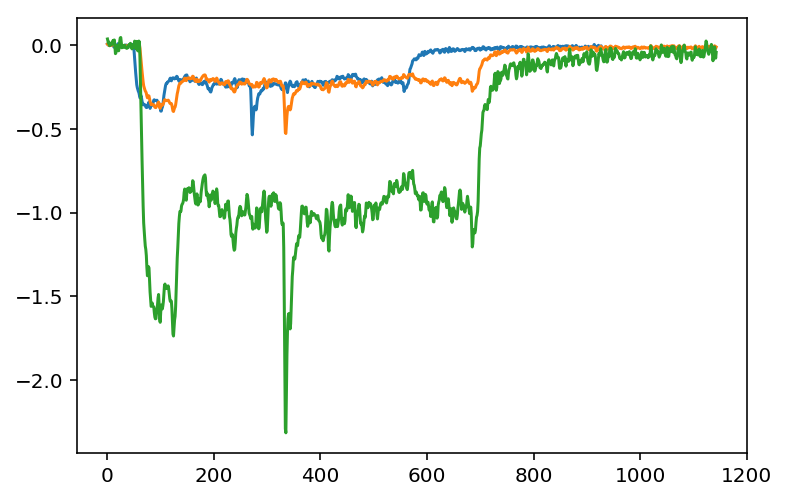

In [611]:
pyplot.plot( ts0.iloc[0] )
pyplot.plot( ts1.iloc[0] )
pyplot.plot( ts2.iloc[0] )

In [612]:
normalised_traces = normaliseTracesFromDataset(dataset_snp, aim_length=600)

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/coconut/icoconut/__main__.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0,0.5,'length')

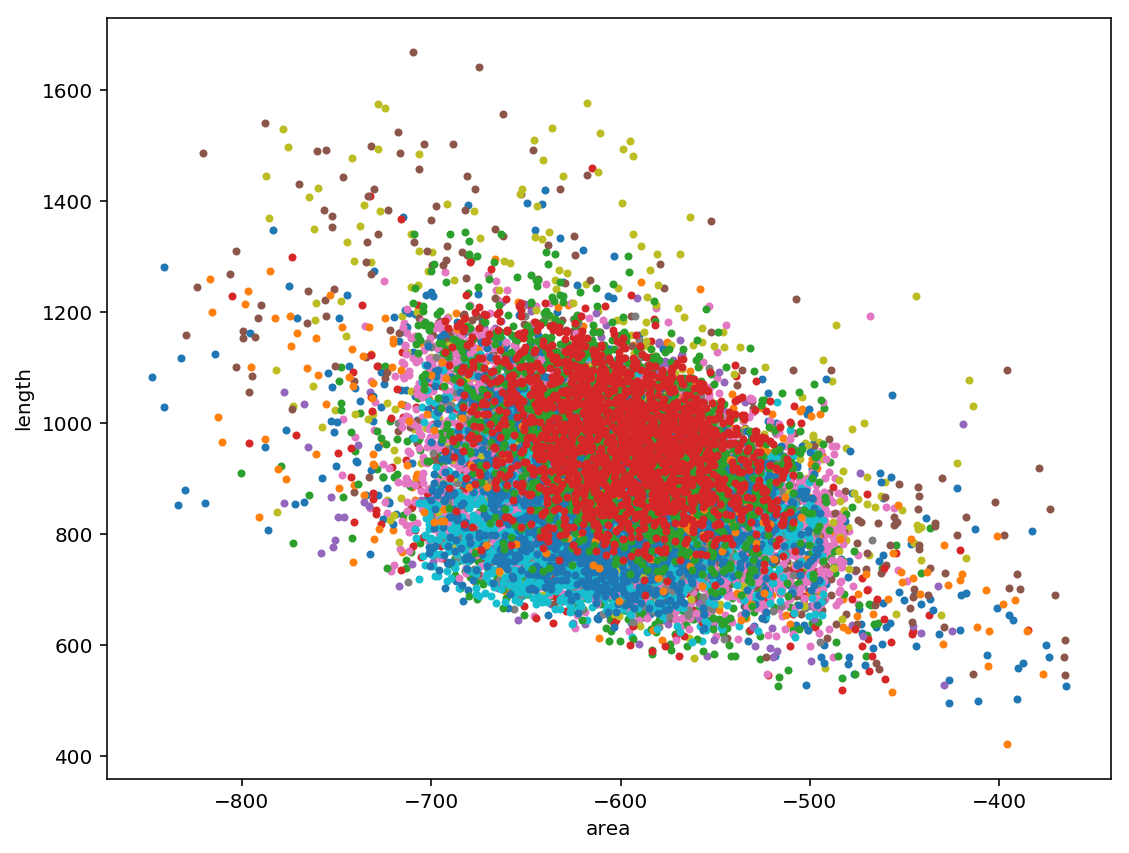

In [613]:
# inspect results (do NOT export this dataset)

ds = dataset_snp


nanopores = ds.nanopore.unique()

pyplot.figure(figsize=[9,7])
for nanopore in nanopores:
    data = normalised_traces[ds.Filter & (ds.nanopore == nanopore)]
    pyplot.plot(data.apply(np.sum), data.apply(len), '.' )
pyplot.xlabel("area")
pyplot.ylabel("length")

It works!

# Other methods

In [ ]:
# Old method for getting data from Nik Erman 

from typing import Dict

def importOneHDF5(path: str) -> Dict:
    raw = h5py.File(path, 'r')
    keys = list( raw.keys() )
    values = map(lambda key: raw[key]["current_nA"][:], keys)
    return dict(zip(keys, values))

def importIntoDataFrame(path: str):
    parameters = barcodeFromFileName(path)
    data = importOneHDF5(path)
    return pd.DataFrame({
        "barcode":  parameters["barcode"],
        "barcodeNum":  int(parameters["barcode"],2),
        "nanoporeId": parameters["NP"],
        "oldId": list(data.keys()), 
        "trace": list(data.values()) 
    })



---

# 1peak Data

data obtained from Jinglin Kong. Thanks!

This dataset is a mess. There are two different experiments: one for protein binding and another one for SNPs. All contain have a small number of events, high variability between pores, and high number of abnormal events. In addition, signal-to-noise ratio is very poor.

Process in two datasets: (1) antibody binding (2) SNP binding data

In [4]:
import re, glob, os
def getNanoporeId(path: str):
    "get nanopore id from file path"
    return re.findall(r'/.{6,12}/events_df', path)[0][1:-10]

def findErmanFilterFile(file: str):
    "just finds the file in that dir"
    return os.path.dirname(file) + "/pore_characterisation.hdf5"

def importErmanFilter(file: str):
    "Import filter indec from earmans analysis"
    f = h5py.File(file, "r")
    return f["filtered_index"].value

def importErmanDataset(file: str, barcode):
    "fixes missing things from Nik Ermans datasets"
    dataset = pd.read_hdf(file)
    dataset["barcode"] = barcode
    dataset["nanopore"] = getNanoporeId(file)
    # get nick erman filters
    filterIndex = ( importErmanFilter( findErmanFilterFile(file) ) )
    dataset["Filter"] = False
    dataset.loc[filterIndex,"Filter"] = True
    return dataset.rename(index=str, columns={"current_nA": "trace"})


ds0 = list(map(
    importErmanDataset$(?, 0), 
    glob.glob("/home/kmisiunas/Data/1peak_middle/old/emptycontrol/*/events_df.hdf5")
))

ds1 = list(map(
    importErmanDataset$(?, 1), 
    glob.glob("/home/kmisiunas/Data/1peak_middle/old/fullcontrol/*/events_df.hdf5")
))
ds0.extend(ds1)
dataset = pd.concat( ds0  , ignore_index=True)

# filter max magnitude
dataset.loc[dataset[dataset.Filter].index[dataset[dataset.Filter].trace.apply(np.min) < -0.8], "Filter"] = False

print("Isolated dataset length:", len(dataset))

Isolated dataset length: 34584


In [ ]:
dataset.to_hdf("/home/kmisiunas/Data/1peak_middle/dataset.hdf5", "1peak", mode = 'w')

### SNP dataset

In [15]:
#

import re, glob, os

def getNanoporeId(path: str):
    "get nanopore id from file path"
    return re.findall(r'[control_quantifying/,SNP/].*/events_df', path)[0][20:-10]

def getBarcode(path: str):
    "get barcode, aka peak?"
    return int( re.findall(r'/sa/.{1,3}control_', path)[0][4] )

def findErmanFilterFile(file: str):
    "just finds the file in that dir"
    return os.path.dirname(file) + "/pore_characterisation.hdf5"

def importErmanFilter(file: str):
    "Import filter indec from earmans analysis"
    f = h5py.File(file, "r")
    return f["filtered_index"].value

def importErmanDataset(file: str):
    "fixes missing things from Nik Ermans datasets"
    dataset = pd.read_hdf(file)
    dataset["barcode"] = getBarcode(file)
    dataset["nanopore"] = getNanoporeId(file)
    # get nick erman filters
    filterIndex = ( importErmanFilter( findErmanFilterFile(file) ) )
    dataset["Filter"] = False
    dataset["area_fC"] = dataset.current_nA.apply(np.sum) * - 1.0
    dataset.loc[filterIndex,"Filter"] = True
    return dataset.rename(index=str, columns={"current_nA": "trace", "area_fC": "area"})



files = glob.glob("/home/kmisiunas/Data/1peak_middle/sa/*/*/*/events_df.hdf5") + \
        glob.glob("/home/kmisiunas/Data/1peak_middle/sa/*/*/events_df.hdf5")

ds0 = list(map(
    importErmanDataset, 
    files
))

dataset = pd.concat( ds0  , ignore_index=True)

print("SA dataset size:", len(dataset))
print("SA filtered dataset :", dataset.Filter.sum())

SA dataset size: 28658
SA filtered dataset : 20916


In [ ]:
dataset.to_hdf("/home/kmisiunas/Data/1peak_middle/dataset_snp.hdf5", "1peak", mode = 'w')

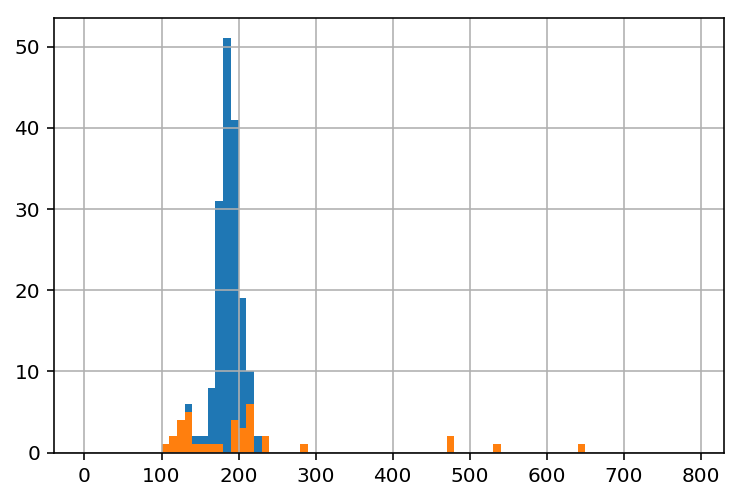

In [223]:
nanopore = dataset.nanopore.unique()[9]

bins = np.arange(0, 800 , 10)

#dataset[dataset.nanopore == nanopore].area_fC.hist(bins=30)
(dataset[(dataset.nanopore == nanopore) ].trace.apply(np.sum)* -3).hist(bins=bins)
(dataset[(dataset.nanopore == nanopore) & (dataset.Filter == False)].trace.apply(np.sum)* -3).hist(bins=bins)




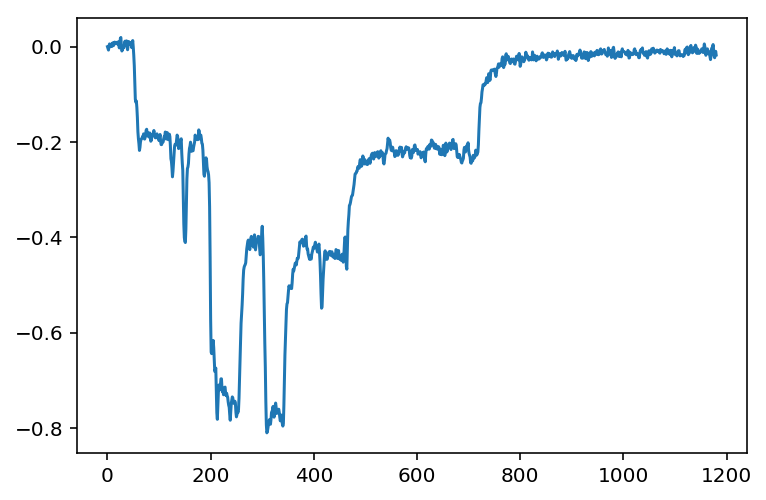

In [183]:
pyplot.plot(
    dataset[(dataset.nanopore == nanopore) & (dataset.trace.apply(np.sum)* -3 >700)].iloc[5].trace
)

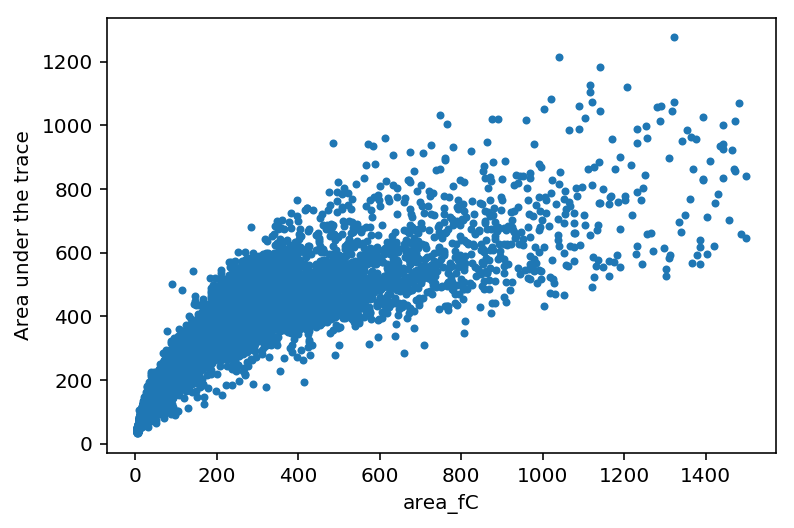

In [11]:
pyplot.plot(
    dataset.area_fC,
    dataset.trace.apply(np.sum) * -4,
    "."
)
pyplot.xlabel("area_fC")
pyplot.ylabel("Area under the trace");

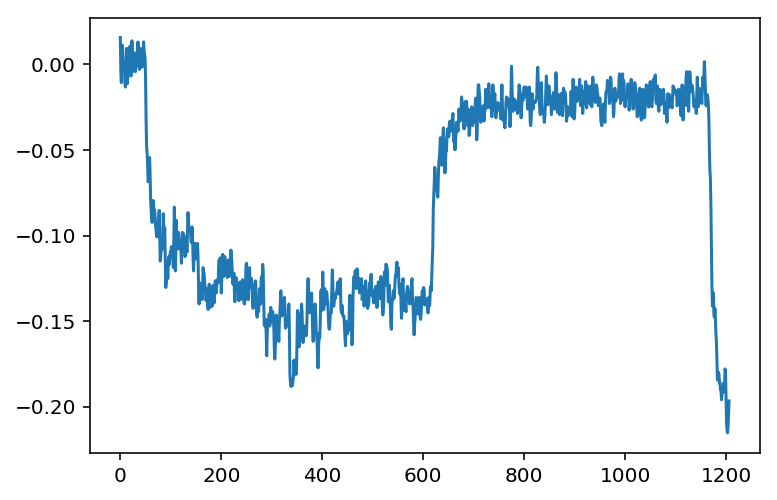

In [108]:
pyplot.plot(
    dataset.sample().trace.values[0]
)

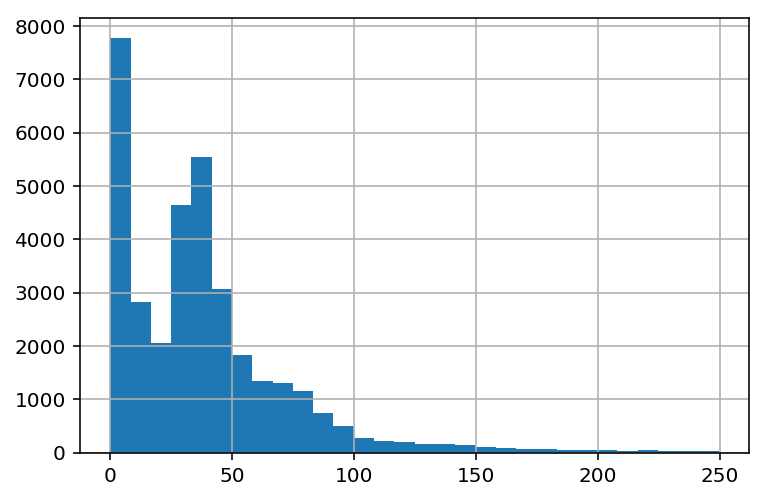

In [123]:
dataset.area_fC.hist(bins = 30)


### Antibody binding

In [17]:
# run above first

def getNanoporeId(path: str):
    "get nanopore id from file path"
    return re.findall(r'control/.*/events_df', path)[0][8:-10]

def getBarcode(path: str):
    "get barcode, aka peak?"
    return int( re.findall(r'/DigAb/.{1,3}control', path)[0][7] )

ds0 = list(map(
    importErmanDataset, 
    glob.glob("/home/kmisiunas/Data/1peak_middle/DigAb/*/*/events_df.hdf5")
))

dataset = pd.concat( ds0  , ignore_index=True)

print("DigAb dataset length:", len(dataset))
print("DigAb filtered dataset length:", dataset.Filter.sum())

DigAb dataset length: 2402
DigAb filtered dataset length: 1474


In [18]:
dataset.to_hdf("/home/kmisiunas/Data/1peak_middle/dataset_antibody.hdf5", "1peak", mode = 'w')

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '1peak'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['trace', 'file', 'nanopore']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


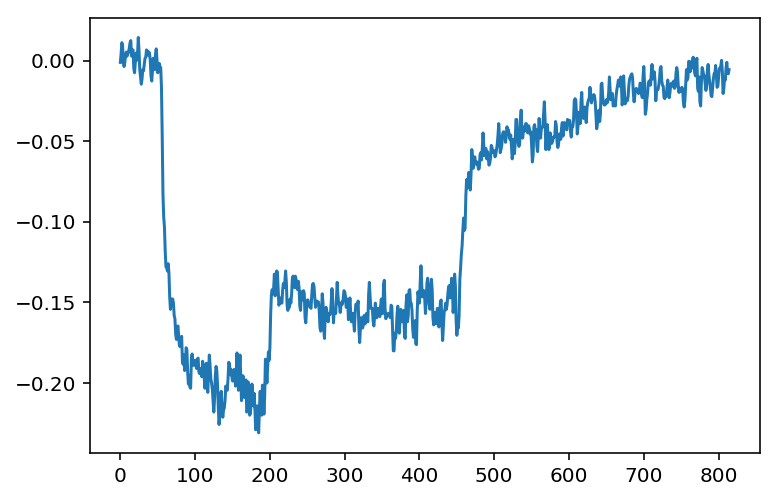

In [120]:
pyplot.plot(
    dataset.sample().trace.values[0]
)

In [73]:
glob.glob("/home/kmisiunas/Data/1peak_middle/DigAb/*/*/events_df.hdf5")

['/home/kmisiunas/Data/1peak_middle/DigAb/100control/160602c6-2/events_df.hdf5',
 '/home/kmisiunas/Data/1peak_middle/DigAb/100control/160602c5-11/events_df.hdf5',
 '/home/kmisiunas/Data/1peak_middle/DigAb/100control/160602c5-2/events_df.hdf5',
 '/home/kmisiunas/Data/1peak_middle/DigAb/100control/160602c6-14/events_df.hdf5',
 '/home/kmisiunas/Data/1peak_middle/DigAb/0control/160528c2-12/events_df.hdf5',
 '/home/kmisiunas/Data/1peak_middle/DigAb/0control/160528c1-6/events_df.hdf5',
 '/home/kmisiunas/Data/1peak_middle/DigAb/0control/160528c1-7/events_df.hdf5',
 '/home/kmisiunas/Data/1peak_middle/DigAb/0control/160324c6/events_df.hdf5',
 '/home/kmisiunas/Data/1peak_middle/DigAb/0control/160528c2-1/events_df.hdf5',
 '/home/kmisiunas/Data/1peak_middle/DigAb/0control/160324c5/events_df.hdf5']

### Time kinetics data

In [30]:

def getNanoporeId(path: str):
    "get nanopore id from file path"
    return re.findall(r'SNP_time_dependent/.*/events_df', path)[0][19:-10]

def getBarcode(path: str):
    "get barcode, aka peak?"
    return np.nan

ds0 = list(map(
    importErmanDataset, 
    glob.glob("/home/kmisiunas/Data/1peak_middle/SNP_time_dependent/*/events_df.hdf5")
))

dataset = pd.concat( ds0  , ignore_index=True)

print("DigAb dataset length:", len(dataset))
print("DigAb filtered dataset length:", dataset.Filter.sum())

DigAb dataset length: 30759
DigAb filtered dataset length: 23446


In [ ]:
dataset.to_hdf("/home/kmisiunas/Data/1peak_middle/dataset_SNP_time_dependent.hdf5", "1peak", mode = 'w')

## 1 Peak filtration 

Just a copy from main data. Expect more filtration is necessary for this dataset because it is messy...

In [61]:
# import  data

dataset = pd.read_hdf("/home/kmisiunas/Data/1peak_middle/dataset_snp.hdf5")

#dataset = pd.read_hdf("/home/kmisiunas/Data/1peak_middle/dataset_SNP_time_dependent.hdf5")

In [64]:
# add extra paramters to the datasets 

#datasetBack = dataset.copy()

#dataset.Filter = True
dataset = dataset[dataset.trace.apply(len) != 0] # some traces simply don't exist?!
dataset = addPerNanopore(addTraceMetrics(dataset));
dataset = addAdvancedMetrics(dataset)

In [65]:
# filtration

def filter_rules(series, limits):
    "returns mask"
    return (series >= np.min(limits)) & (series <= np.max(limits))

def filter_gaussain(data, std_fisrt, verbose = False):
    "gaussain filter after selecting first window. Return [mean, std]"
    raw_std = np.std(data)
    raw_mean = np.mean(data)
    points = data[(data > raw_mean - std_fisrt*raw_std) & (data < raw_mean + std_fisrt*raw_std)]
    y, x = np.histogram(points)
    x = (x[1:] + x[:-1]) / 2
    
    def gaussian(x, amp, cen, wid):
        return amp * np.exp(-(x-cen)**2 /wid)
    
    from scipy.optimize import curve_fit
    init_vals = [np.max(y), raw_mean, raw_std]     # for [amp, cen, wid]
    try:
        best_vals, covar = curve_fit(gaussian, x, y, p0=init_vals)
        mean = best_vals[1]
        std  = np.sqrt( best_vals[2] /2 )
    except:
        print("Warrning! Filed to converge in filter_gaussain. going back to simple estimates")
        mean = raw_mean
        std = raw_std
    
    if verbose:
        print("raw: mean=", np.mean(ds.area), "; std=",np.std(ds.area))
        print("fit: mean=", mean, "; std=",std)
        print("after filter: mean=", np.mean(points), "; std=",np.std(points))
        binwidth = np.diff(x)[0]
        pyplot.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth))
        pyplot.plot(x,y, "o")
        x_test = np.arange(min(points), max(points), binwidth/10.0)
        pyplot.plot(x_test, gaussian(x_test, best_vals[0], best_vals[1], best_vals[2]), 'r')
        pyplot.plot([mean - 2.3*std, mean + 2.3*std],[5,5], "rX")
        
    return [mean, std]

def filter_area(ds, verbose = False):
    "returns limits"
    mean, std = filter_gaussain(ds.area, 1, verbose = verbose)
    return [mean - 2.0*std, mean + 2.0*std]

def filter_TraceSmoothMax(ds):
    "filter out events with unusually high traces"
    # paramters tunned by manual inspection on 2018-01-19
    level = ds.UnfoldedLevel.iloc[0]
    return [2.3*level, 0.8*level]

def filter_TraceMax(ds):
    "returns limits"
    # paramters tunned by manual inspection on 2018-01-19
    level = ds.UnfoldedLevel.iloc[0]
    return sorted([level, level*3.2])

# def filter_TraceStd(ds):
#     "returns limits"
#     std = np.std(ds.TraceStd)
#     mean = np.mean(ds.TraceStd)
#     level = ds.UnfoldedLevel.iloc[0]
#     return [mean - 1.9*std, np.min([ np.abs(level),mean + 1.9*std]) ]

# def filter_TraceMean(ds):
#     "returns limits"
#     level = ds.UnfoldedLevel.iloc[0]
#     return sorted([level*0.3, level])


def filterPerNanoporeAndBarcode(ds):
    "filter per nanopore based on all the filters"
    if 'barcode' not in ds.columns:
        return filterPerNanopore(ds)
    nanopores = ds.nanopore.unique()
    barcodes =  ds.barcode.unique()
    filters = ds.Filter 
    import itertools
    for nanopore, barcode in itertools.product(nanopores, barcodes):
        sel = (ds.nanopore == nanopore) & (ds.barcode == barcode)
        if sel.sum() > 0:
            data = ds[sel]
            filters[sel] =  filter_rules(data.area, filter_area(data)) &\
                            filter_rules(data.TraceSmoothMax, filter_TraceSmoothMax(data)) &\
                            filter_rules(data.TraceMax, filter_TraceMax(data))
    
    # add back to ds: 
    filters = filters.fillna(False)
    ds["Filter"] = filters
    return ds

def filterPerNanopore(ds):
    "filter per nanopore based on all the filters"
    nanopores = ds.nanopore.unique()
    filters = ds.Filter 
    import itertools
    for nanopore in nanopores:
        sel = (ds.nanopore == nanopore)
        if sel.sum() > 0:
            data = ds[sel]
            filters[sel] =  filter_rules(data.area, filter_area(data)) &\
                            filter_rules(data.TraceSmoothMax, filter_TraceSmoothMax(data)) &\
                            filter_rules(data.TraceMax, filter_TraceMax(data))
    
    # add back to ds: 
    filters = filters.fillna(False)
    ds["Filter"] = filters
    return ds


In [125]:
# Counts

tmp = dataset[["barcode", "nanopore"]].copy()
tmp.groupby(tmp.columns.tolist(),as_index=False).size()

Series([], dtype: int64)

barcode:  0


/home/kmisiunas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


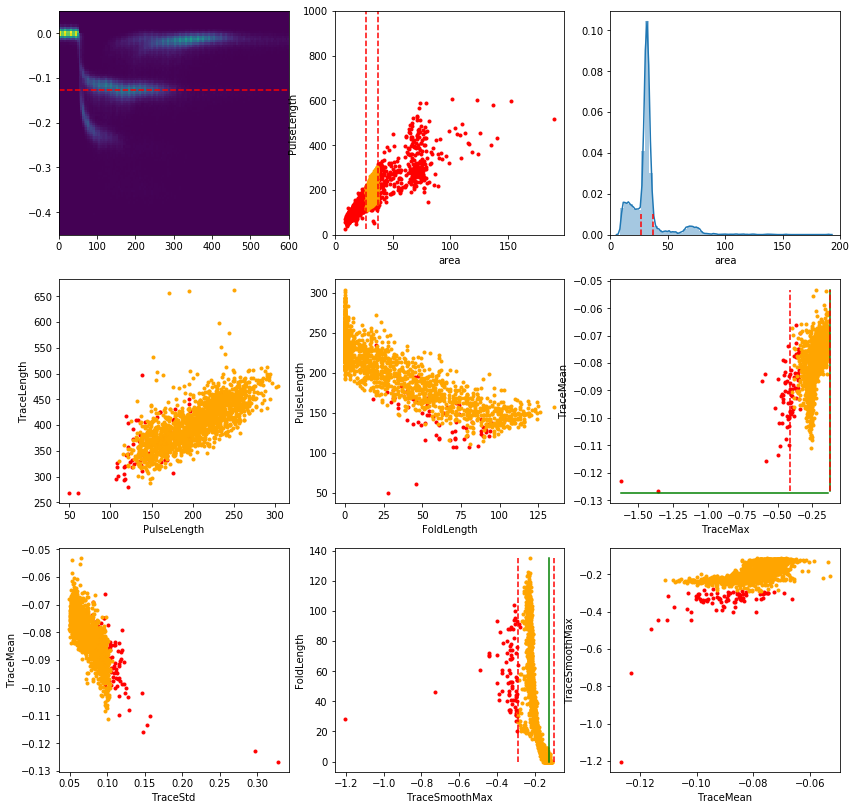

In [69]:
# Inspection

ds = dataset  # select dataset

nanopores = ds.nanopore.unique()
nanopore = '/1peak_middle/sa/0control_SNP/160718c1-3 blank' #nanopores[4]
sel = ds.nanopore == nanopore

# barcodes =  ds[sel].barcode.unique()
# print("barcodes in nanopore=", nanopore, ":", barcodes)
# barcode = barcodes[0]
# sel = sel & (ds.barcode == barcode) 

data = ds[sel]
print("barcode: ", data.iloc[10].barcode)

def plotPrarams(ds, x, y):
    #selNB = ds.nbell_barcode < 8
    sel = ds.Filter
    pyplot.plot(ds[~sel][x], ds[~sel][y], '.', color='red' )
    pyplot.plot(ds[sel][x], ds[sel][y], '.', color='orange' )
    #pyplot.plot(ds[selNB][x], ds[selNB][y], '.' )
    pyplot.xlabel(x)
    pyplot.ylabel(y)
    
def minMax(arr): return [np.min(arr), np.max(arr)]

unfolded_level = data.UnfoldedLevel.iloc[0]


# area vs something else
pyplot.figure(figsize=[14,14])


pyplot.subplot(3,3,1)
points = Quipu.process.getIndexedTraces(data)
pyplot.hist2d(points[:,0], points[:,1], 
    bins=(70*2, 50*2),
    range = [[0, 600], [-0.45, 0.05]],
    cmax = 100000/4 # clip max
)
pyplot.plot([0,600], [unfolded_level]*2, 'r--')


pyplot.subplot(3,3,2)
plotPrarams(data, 'area', 'PulseLength')
limits_area = filter_area(data)
pyplot.ylim([0,1000])
pyplot.plot([np.min(limits_area)]*2, minMax(data.PulseLength), 'r--')
pyplot.plot([np.max(limits_area)]*2 ,minMax(data.PulseLength), 'r--')

pyplot.subplot(3,3,3)
seaborn.distplot( data.area )
pyplot.xlim([0,200])
pyplot.plot([np.min(limits_area)]*2, [0,0.01], 'r--')
pyplot.plot([np.max(limits_area)]*2 ,[0,0.01], 'r--')

# Refinement 
# from here remove anything outside the area filter
data = data[filter_rules(data.area, limits_area)]
# reapply filters to see redundand filters
data['Filter'] = filter_rules(data.TraceSmoothMax, filter_TraceSmoothMax(data)) &\
                 filter_rules(data.TraceMax, filter_TraceMax(data))

pyplot.subplot(3,3,4)
plotPrarams(data, 'PulseLength', 'TraceLength')

pyplot.subplot(3,3,5)
plotPrarams(data, 'FoldLength', 'PulseLength')


pyplot.subplot(3,3,6)
plotPrarams(data, 'TraceMax', 'TraceMean')
pyplot.plot([unfolded_level]*2 ,minMax(data.TraceMean), 'g')
pyplot.plot(minMax(data.TraceMax),[unfolded_level]*2 , 'g')
limits_TraceMax = filter_TraceMax(data)
pyplot.plot([np.min(limits_TraceMax)]*2, minMax(data.TraceMean), 'r--')
pyplot.plot([np.max(limits_TraceMax)]*2 ,minMax(data.TraceMean), 'r--')

pyplot.subplot(3,3,7)
plotPrarams(data, 'TraceStd', 'TraceMean')


pyplot.subplot(3,3,8)
plotPrarams(data, 'TraceSmoothMax', 'FoldLength')
limits_TraceSmoothMax = filter_TraceSmoothMax(data)
pyplot.plot([unfolded_level]*2 ,minMax(data.FoldLength), 'g')
pyplot.plot([np.min(limits_TraceSmoothMax)]*2, minMax(data.FoldLength), 'r--')
pyplot.plot([np.max(limits_TraceSmoothMax)]*2 ,minMax(data.FoldLength), 'r--')

pyplot.subplot(3,3,9)
plotPrarams(data,  'TraceMean', 'TraceSmoothMax')


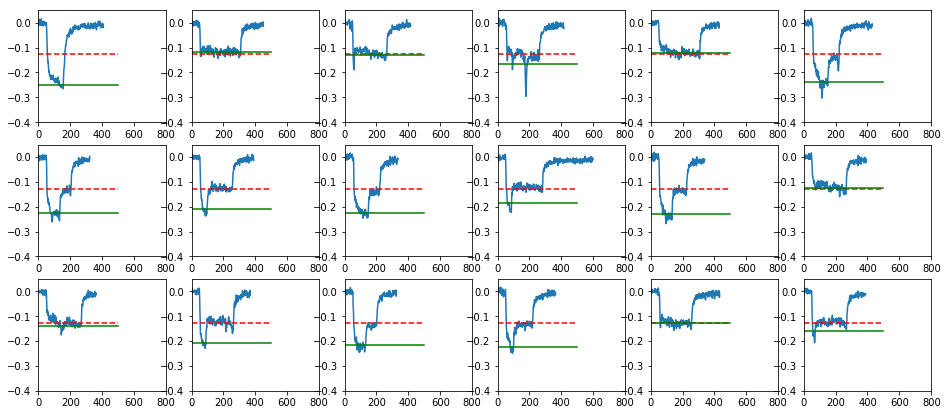

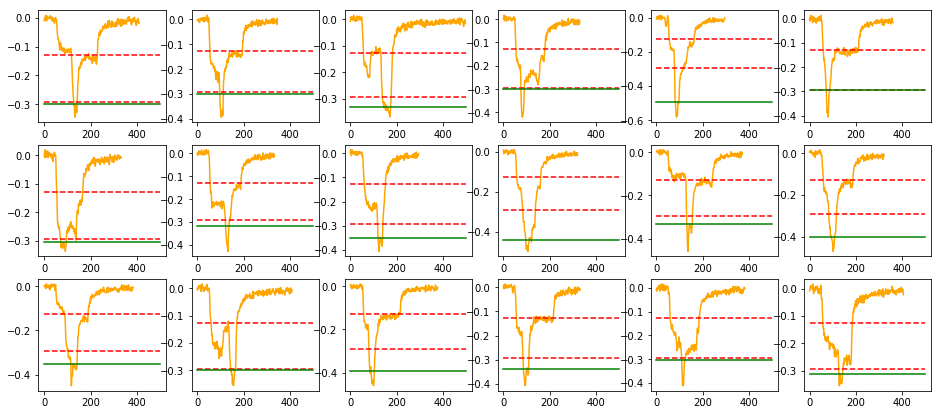

In [71]:
# inspect traces included and excluded by the filters

pyplot.figure(figsize=[16,7])
examples_included = data[data.Filter].sample(3*6)
for i in range(3*6):
    one = examples_included.iloc[i]
    pyplot.subplot(3,6,i+1)
    pyplot.plot(one.trace)
    pyplot.plot([0,500], [one.UnfoldedLevel]*2, 'r--')
    pyplot.plot([0,500], [one.TraceSmoothMax]*2, 'g')
    pyplot.ylim([-0.4, 0.05])
    pyplot.xlim([0, 800])
    
pyplot.figure(figsize=[16,7])
n = np.min([3*6 , len(data[~data.Filter])])
examples_excluded = data[~data.Filter].sample(n)
for i in range(n):
    one = examples_excluded.iloc[i]
    pyplot.subplot(3,6,i+1)
    pyplot.plot(one.trace, color='orange')
    pyplot.plot([0,500], [one.UnfoldedLevel]*2, 'r--')
    pyplot.plot([0,500], [one.UnfoldedLevel*2.3]*2, 'r--')
    pyplot.plot([0,500], [one.TraceSmoothMax]*2, 'g')

1763    0
Name: barcode, dtype: int64


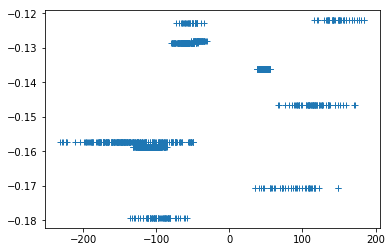

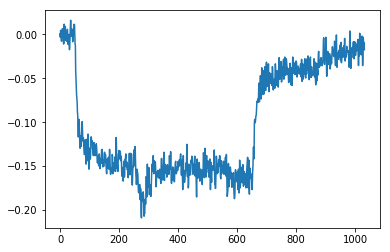

In [53]:
dataset_antibody = pd.read_hdf("/home/kmisiunas/Data/1peak_middle/dataset_antibody.hdf5")

data2 = dataset_antibody[dataset_antibody.Filter]
pyplot.plot( data2.area * (data2.barcode -0.5)*2, data2.UnfoldedLevel, '+' )

pyplot.figure()
tmp = data2.sample()
pyplot.plot( tmp.trace.iloc[0] )
print(tmp.barcode)

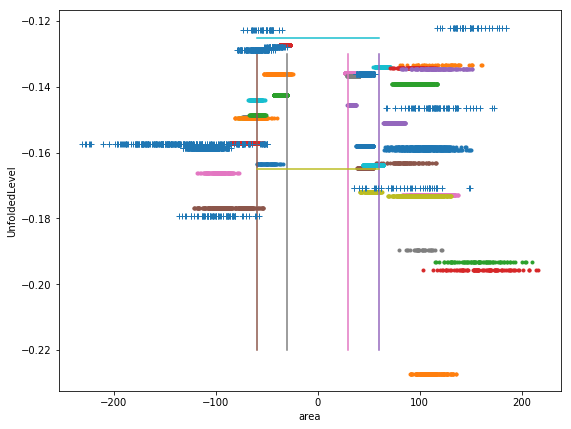

In [73]:
# compare distributions 

nanopores = dataset.nanopore.unique()

pyplot.figure(figsize=[9,7])
for nanopore in nanopores:
    data = dataset[dataset.Filter & (dataset.nanopore == nanopore)]
    pyplot.plot(data.area * (data.barcode -0.5)*2, data.UnfoldedLevel, '.' )
pyplot.xlabel("area")
pyplot.ylabel("UnfoldedLevel")
pyplot.plot([60]*2, [-0.22,-0.13])
pyplot.plot([-60]*2, [-0.22,-0.13])
pyplot.plot([30]*2, [-0.22,-0.13])
pyplot.plot([-30]*2, [-0.22,-0.13])
pyplot.plot([-60,60], [-0.165]*2)
pyplot.plot([-60,60], [-0.125]*2)

data2 = dataset_antibody[dataset_antibody.Filter]
pyplot.plot( data2.area * (data2.barcode -0.5)*2, data2.UnfoldedLevel, '+' )

Need to selectrelavant training data from all this 

In [74]:
nanopores = dataset.nanopore.unique()
sel_pores = []

for pore in nanopores:
    data = dataset[dataset.Filter & (dataset.nanopore == pore)]
    area = data.area.mean()
    undolded_level = data.UnfoldedLevel.mean()
    if area < 62 and undolded_level < -0.125 and undolded_level > -0.165:
        sel_pores.append(pore)


sel_pores

['/1peak_middle/sa/0control_quantifying/0302 blank carrier/c10',
 '/1peak_middle/sa/0control_quantifying/0302 blank carrier/c11',
 '/1peak_middle/sa/0control_quantifying/0302 blank carrier/c8',
 '/1peak_middle/sa/0control_quantifying/0302 blank carrier/c6',
 '/1peak_middle/sa/100control_SNP/160713c1-1 blank01',
 '/1peak_middle/sa/100control_SNP/160713c1-2 blank02',
 '/1peak_middle/sa/100control_SNP/160713c1-016 blank05',
 '/1peak_middle/sa/100control_SNP/160617c1-4 blank',
 '/1peak_middle/sa/100control_SNP/160608c1-14blank',
 '/1peak_middle/sa/100control_SNP/160521c1-1 c+strep',
 '/1peak_middle/sa/0control_SNP/160718c1-2 blank',
 '/1peak_middle/sa/0control_SNP/160718c1-01 blank',
 '/1peak_middle/sa/0control_SNP/160718c1-3 blank']

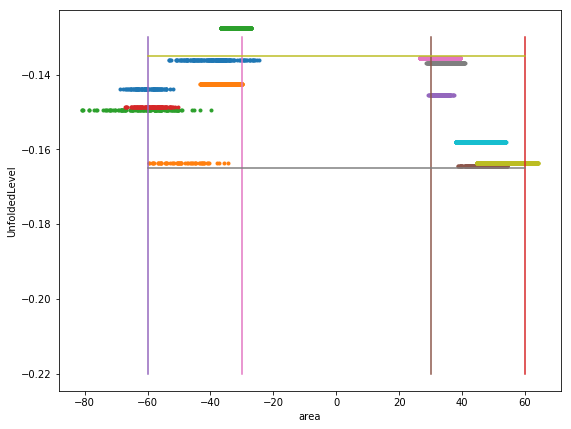

In [75]:
# selected distributions 

nanopores = sel_pores

pyplot.figure(figsize=[9,7])
for nanopore in nanopores:
    data = dataset[dataset.Filter & (dataset.nanopore == nanopore)]
    pyplot.plot(data.area * (data.barcode -0.5)*2, data.UnfoldedLevel, '.' )
pyplot.xlabel("area")
pyplot.ylabel("UnfoldedLevel")
pyplot.plot([60]*2, [-0.22,-0.13])
pyplot.plot([-60]*2, [-0.22,-0.13])
pyplot.plot([30]*2, [-0.22,-0.13])
pyplot.plot([-30]*2, [-0.22,-0.13])
pyplot.plot([-60,60], [-0.165]*2)
pyplot.plot([-60,60], [-0.135]*2)

In [77]:
# Selection for antibody data (assuming they are similar enough)

nanopores = dataset_antibody.nanopore.unique()
sel_pores_antibody = []

for pore in nanopores:
    data = dataset_antibody[dataset_antibody.Filter & (dataset_antibody.nanopore == pore)]
    area = data.area.mean()
    undolded_level = data.UnfoldedLevel.mean()
    if area < 62 and undolded_level < -0.125 and undolded_level > -0.165:
        sel_pores_antibody.append(pore)


sel_pores_antibody


['160602c5-2', '160528c2-12', '160528c1-6']

In [41]:
dataset_time_SNP = pd.read_hdf("/home/kmisiunas/Data/1peak_middle/dataset_SNP_time_dependent.hdf5")

dataset_time_SNP = dataset_time_SNP[dataset_time_SNP.trace.apply(len) != 0] # some traces simply don't exist?!
dataset_time_SNP = addPerNanopore(addTraceMetrics(dataset_time_SNP));
dataset_time_SNP = addAdvancedMetrics(dataset_time_SNP)

Text(0,0.5,'UnfoldedLevel')

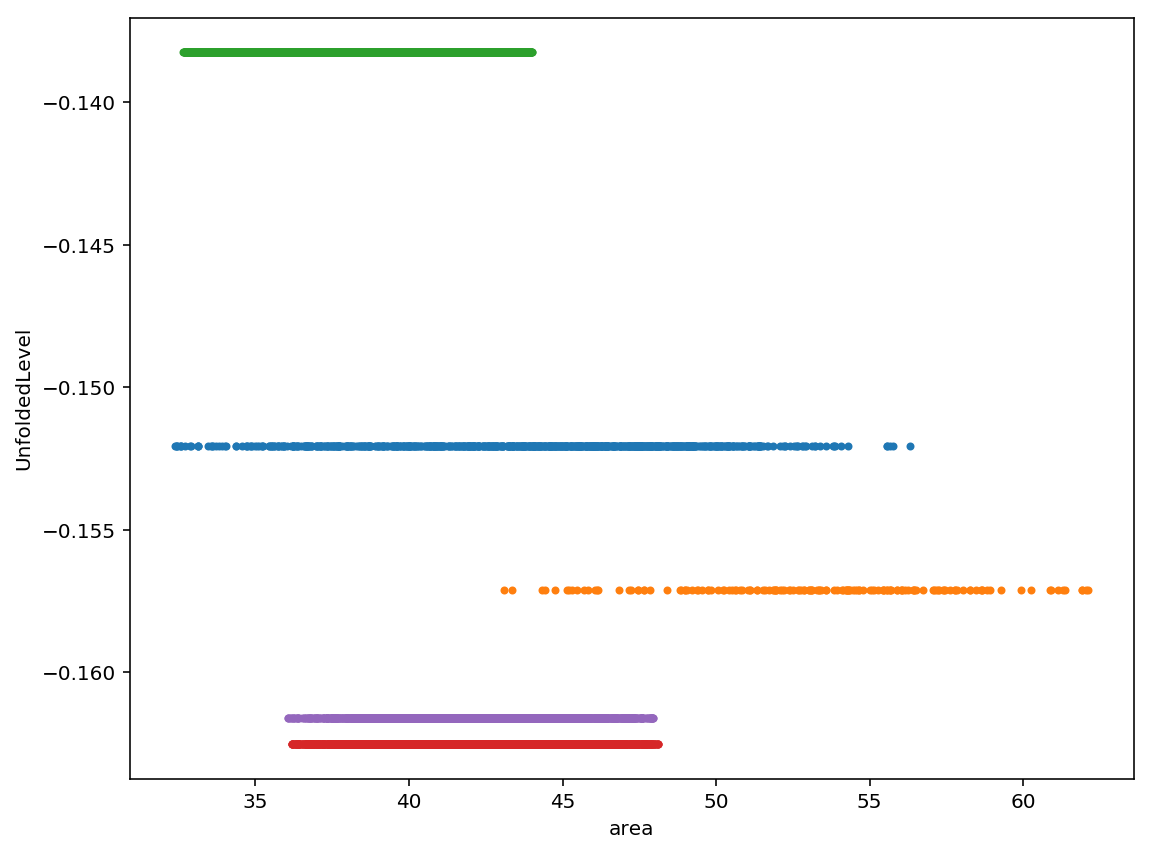

In [42]:
nanopores = dataset_time_SNP.nanopore.unique()

pyplot.figure(figsize=[9,7])
for nanopore in nanopores:
    data = dataset_time_SNP[dataset_time_SNP.Filter & (dataset_time_SNP.nanopore == nanopore)]
    pyplot.plot(data.area , data.UnfoldedLevel, '.' )
pyplot.xlabel("area")
pyplot.ylabel("UnfoldedLevel")

### Prepare output 

Now need to prepare training/test data and also time varying data. Will apply the filter to all the data and save them into tables

In [76]:
# apply filters to train/test

dataset = pd.read_hdf("/home/kmisiunas/Data/1peak_middle/dataset_snp.hdf5")

dataset = dataset[dataset.trace.apply(len) != 0] # some traces simply don't exist?!
dataset = addPerNanoporeAndBarcode(addTraceMetrics(dataset));
dataset = addAdvancedMetrics(dataset)

# only include selected traces
dataset = dataset[dataset.nanopore.isin(sel_pores)]

print("Before filtration number of traces: ", len(dataset))
dataset = filterPerNanopore( dataset )
print("After filtration number of traces: ", dataset.Filter.sum())

dataset.to_hdf("/home/kmisiunas/Data/1peak_middle/processed/dataset_snp.hdf5", "1peak", mode = 'w')

Before filtration number of traces:  22630
After filtration number of traces:  14718


/home/kmisiunas/anaconda3/lib/python3.6/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '1peak'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['trace', 'file', 'nanopore']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [162]:
# apply filters to time series data 

dataset = pd.read_hdf("/home/kmisiunas/Data/1peak_middle/dataset_SNP_time_dependent.hdf5")

dataset = dataset[dataset.trace.apply(len) != 0] # some traces simply don't exist?!
dataset = addPerNanopore(addTraceMetrics(dataset));
dataset = addAdvancedMetrics(dataset)

# only include selected traces
#dataset = dataset[dataset.nanopore.isin(sel_pores)]

print("Before filtration number of traces: ", len(dataset))
dataset = filterPerNanopore( dataset )
print("After filtration number of traces: ", dataset.Filter.sum())

dataset.to_hdf("/home/kmisiunas/Data/1peak_middle/processed/dataset_snp_time_dependent.hdf5", "1peak", mode = 'w')

Before filtration number of traces:  30759
After filtration number of traces:  19447


/home/kmisiunas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kmisiunas/anaconda3/lib/python3.6/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '1peak'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['trace', 'file', 'group', 'nanopore']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [79]:
# apply filters to train/test 
# INCLUDE antibody binding data because it is very similar 

dataset = pd.read_hdf("/home/kmisiunas/Data/1peak_middle/dataset_snp.hdf5")

dataset = dataset[dataset.trace.apply(len) != 0] # some traces simply don't exist?!
dataset = addPerNanoporeAndBarcode(addTraceMetrics(dataset));
dataset = addAdvancedMetrics(dataset)

# only include selected traces
dataset = dataset[dataset.nanopore.isin(sel_pores)]

print("Before filtration number of traces: ", len(dataset))
dataset = filterPerNanopore( dataset )
print("After filtration number of traces: ", dataset.Filter.sum())

ds1 = dataset

# ANTIBODY data
dataset = pd.read_hdf("/home/kmisiunas/Data/1peak_middle/dataset_antibody.hdf5")

dataset = dataset[dataset.trace.apply(len) != 0] # some traces simply don't exist?!
dataset = addPerNanoporeAndBarcode(addTraceMetrics(dataset));
dataset = addAdvancedMetrics(dataset)

# only include selected traces
dataset = dataset[dataset.nanopore.isin(sel_pores_antibody)]

print("Before filtration number of traces: ", len(dataset))
dataset = filterPerNanopore( dataset )
print("After filtration number of traces: ", dataset.Filter.sum())

dataset = pd.concat([ds1, dataset], ignore_index=True)

dataset.to_hdf("/home/kmisiunas/Data/1peak_middle/processed/dataset_snp_w_antibody.hdf5", "1peak", mode = 'w')

Before filtration number of traces:  22630
After filtration number of traces:  14718
Before filtration number of traces:  810
After filtration number of traces:  479


/home/kmisiunas/anaconda3/lib/python3.6/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '1peak'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['trace', 'file', 'nanopore']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


### Notes

2018-03-13
nanopore `/1peak_middle/sa/0control_quantifying/0302 blank carrier/c6` is 

In [96]:
data.iloc[0].nanopore

'/1peak_middle/sa/0control_quantifying/0302 blank carrier/c6'

In [97]:
data.iloc[0].barcode

0

In [138]:


measureUnfoldedLevel(data, verbose=0)

-0.15216904124964245

In [130]:
from Quipu.process import measureUnfoldedLevel


# Clean dataset for public 

Shrink the size by removing the unnecessary components. They can be recomputed if someone needs them using this notebook.



In [2]:
dataset =         pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/dataset.hdf5")
datasetTestEven = pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestEven.hdf5")
datasetTestOdd =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestOdd.hdf5")
datasetTestMix =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestMix.hdf5")
datasetWithAntibodies =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetIndividualWithAntibodies.hdf5")
datasetMultiplexed =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetMultiplexed.hdf5")
datasetExtra =    pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetExtra.hdf5")



In [3]:
dataset.keys()

Index(['barcode', 'nanopore', 'trace', 'Filter', 'nbell_quality',
       'nbell_peaks_first_half', 'nbell_peaks_second_half', 'nbell_barcode',
       'nbell_positive_barcode', 'Bound', 'TraceMax', 'Area', 'TraceStd',
       'TraceMean', 'TraceMean20', 'TraceMeanH1', 'TraceMeanH2', 'TraceLength',
       'TraceSmooth', 'TraceSmoothMax', 'TraceSmoothStd',
       'TraceSmoothStdRatio', 'UnfoldedLevel', 'Folded', 'human_barcode',
       'area', 'PulseLength', 'FoldLength'],
      dtype='object')

In [11]:
len(dataset)

41560

In [31]:
useful_keys = ['barcode', 'nanopore', 'trace', 'Filter', 'nbell_quality', 'nbell_barcode',
       'nbell_positive_barcode', 'Bound', 'Area', 'UnfoldedLevel', 'human_barcode']

dataset[:20000][useful_keys].to_hdf("data/dataset_part1.hdf5", "NBell2016", mode = 'w')
dataset[20000:][useful_keys].to_hdf("data/dataset_part2.hdf5", "NBell2016", mode = 'w')

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['barcode', 'trace', 'human_barcode']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [32]:
useful_keys = ['barcode', 'nanopore', 'trace', 'Filter', 'nbell_quality','nbell_barcode',
       'nbell_positive_barcode', 'Bound', 'Area', 'UnfoldedLevel']

datasetTestEven[useful_keys].to_hdf("data/datasetTestEven.hdf5", "NBell2016", mode = 'w')
datasetTestOdd[useful_keys].to_hdf("data/datasetTestOdd.hdf5", "NBell2016", mode = 'w')
datasetTestMix[useful_keys].to_hdf("data/datasetTestMix.hdf5", "NBell2016", mode = 'w')

useful_keys = ['barcode', 'nanopore', 'trace', 'Filter', 'nbell_quality', 'Bound', 'Area', 'UnfoldedLevel']

datasetWithAntibodies[:20000][useful_keys].to_hdf("data/datasetWithAntibodies_part1.hdf5", "NBell2016", mode = 'w')
datasetWithAntibodies[20000:][useful_keys].to_hdf("data/datasetWithAntibodies_part2.hdf5", "NBell2016", mode = 'w')
datasetExtra[useful_keys].to_hdf("data/datasetExtra.hdf5", "NBell2016", mode = 'w')


/home/kmisiunas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['barcode', 'trace']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
